In [67]:
from natto.process.kNearestNeighbours import timeSliceNearestNeighbor, timeSliceNearestNeighborOG
from natto import input, process
from natto.out import draw
from natto.process import cluster, util
from natto.process.cluster import k2means, hungutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import importlib
from umap.umap_ import UMAP
from pynndescent import NNDescent
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score as ARI
from tslearn.clustering import TimeSeriesKMeans
import anndata as ad
from anndata import AnnData
import scanpy as sc
from scanpy.pp import pca as PCA
from scanpy.pp import neighbors, subsample, scale, calculate_qc_metrics, combat
import importlib
#importlib.reload(kNearestNeighbours)
importlib.reload(process)

<module 'natto.process' from '/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/natto/natto/process/__init__.py'>

In [2]:
def preprocess(annDataList, 
               selector='natto', 
               selectslice='all',
               donormalize = True,
               make_even=True,
               joint_space=True,
               selectgenes=800,
               min_counts=3,
               pca=20,
               umaps=[10,2]):
    print("Preprocessing")
    Data  = process.Data().fit(annDataList, 
                               selector=selector, 
                               selectslice=selectslice,
                               visual_ftsel=False, 
                               joint_space=joint_space,
                               donormalize=donormalize,
                               normTogether=False,
                               make_even=make_even,
                               plotPCA=True,
                               scale=False,
                               sortfield=0,
                               selectgenes=selectgenes, #default is 800
                               min_counts=min_counts,
                               pca=pca, #default is 20  
                               umaps=umaps
                              )
    Data.sort_cells(0)

    return Data   

In [74]:
### Load Data
t0 = time.time()
subsampleNum = 2000 # None or int
datasets = 'sim' # Can be 'sim', 'simLarge', MouseCortex', 'rawMouseCortex', Waterston', 'pancreas', 'pancreasv2'
useMarkerGenes=False
loadedData = []
loadedLabels = []

print("Loading Data")
if datasets == 'sim':
    ### Best settings are
        # k_from_neighbors=10, 
        # k_from_same=14, 
        # neighbor_distance='max' or '3quartile'
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/sim_data/"
    for i in range(5):
        #loadedData.append(pd.read_csv(f'{inputDirectory}time{i}.csv', sep=',', header=None).values)
        loadedLabels.append(pd.read_csv(f'{inputDirectory}time{i}_labels.csv', sep=',', header=None)[0].values.astype(int))
        loadedData.append(ad.read_csv(f'{inputDirectory}time{i}.csv'))
        #loadedLabels.append(ad.read_csv(f'{inputDirectory}time{i}_labels.csv'))

    #combat(loadedData)
    Labels=loadedLabels
    n_components=4
    #for index, data in enumerate(loadedData):
        #loadedData[index] = data[np.random.choice(data.shape[0], subsampleNum, replace=False), :]
    for data in loadedData:
        print(len(data))
        
        
if datasets == 'simLarge':
    ### Same sim data but with an additional large moving cluter
    ### Best settings are
        # k_from_neighbors=10, 
        # k_from_same=14, 
        # neighbor_distance='max' or '3quartile'
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/sim_data/"
    for i in range(5):
        loadedData.append(pd.read_csv(f'{inputDirectory}wLargeCluster_time{i}.csv', sep=',', header=None).values)
        loadedLabels.append(pd.read_csv(f'{inputDirectory}wLargeCluster_time{i}_labels.csv', sep=',', header=None)[0].values.astype(int))
    Labels=[l for l in loadedLabels]
    n_components=5
    #for index, data in enumerate(loadedData):
        #loadedData[index] = data[np.random.choice(data.shape[0], subsampleNum, replace=False), :]
    for data in loadedData:
        print(len(data))


elif datasets == 'MouseCortex':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/MouseCortexData/"
    for index, item in enumerate(['e11', 'e13', 'e15', 'e17']):
        print(index)
        data = ad.read_csv(inputDirectory + item + '.csv').T
        label = pd.read_csv(inputDirectory + item + 'Labels.csv', usecols=["cluster"])['cluster'].to_numpy()
        
        data.obs['labels'] = label
        #geneNames = pd.read_csv(inputDirectory + item + '/genes.tsv', sep='\t', header=None)

        loadedData.append(data)
        for data in loadedData:
            if data.X.shape[0] > subsampleNum:
                subsample(data,
                    fraction=None,
                    n_obs=subsampleNum,
                    random_state=0,
                    copy=False)

                
elif datasets == 'rawMouseCortex':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/MouseCortexData/"
    batch = 2
    for index, item in enumerate(['e11', 'e13', 'e15', 'e17']):
        print(index)
        data = ad.read_csv(inputDirectory + 'raw' + item + '.csv')
        
        data=data.T
        
        label = pd.read_csv(inputDirectory + item + 'Labels.csv', usecols=["cluster"])['cluster'].to_numpy()
        data.obs['labels'] = label
        #geneNames = pd.read_csv(inputDirectory + item + '/genes.tsv', sep='\t', header=None)

        if index==2:
            if batch==1:
                data=data[:1000,:]
            elif batch==2:
                data=data[-1000:,:]
        
        loadedData.append(data)
    for data in loadedData:
        if data.X.shape[0] > subsampleNum:
            subsample(data,
                fraction=None,
                n_obs=subsampleNum,
                random_state=0,
                copy=False)
        print(data.shape)


elif datasets == "MouseCerebellum":
    EorP = 'PE'
    
    inputDirectory = "/Volumes/Expansion/Tempora/MouseCerebellumData/"
    if EorP == 'E':
        timeNames = ['E10', 'E12', 'E14', 'E16', 'E18']
    elif EorP == 'P':
        timeNames = ['P0', 'P5', 'P7', 'P14']
    elif EorP == "PE":
        timeNames = ['E10', 'E12', 'E14', 'E16', 'E18', 'P0', 'P5', 'P7', 'P14']
    
    for index, item in enumerate(timeNames):
        print(index)
        #data = ad.read_csv(inputDirectory + 'raw' + item + '.csv')
        data = sc.read(inputDirectory + 'raw' + item + '.csv', cache=True)
        data=data.T
        print(data.shape)
        label = pd.read_csv(inputDirectory + item + 'Labels.csv', usecols=["label"])['label'].to_numpy()
        print(label.shape)
        data.obs['labels'] = label
        
        #for index, data in enumerate(loadedData):

        loadedData.append(data)
        data = data[data.obs['labels'].to_numpy() != -1]
        loadedData[index] = data

        if data.X.shape[0] > subsampleNum:
            subsample(data,
                fraction=None,
                n_obs=subsampleNum,
                random_state=0,
                copy=False)

elif datasets == 'immune':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/immune_stim/"
    for index, dataName in enumerate(['8', '9']):
        print(index)
        data = input.loadpbmc(path=inputDirectory+dataName)
        loadedData.append(data)
        
        if data.X.shape[0] > subsampleNum:
            subsample(data,
                fraction=None,
                n_obs=subsampleNum,
                random_state=0,
                copy=False)

            
elif datasets == 'Waterston':
    ### Decent settings are
        # k_from_neighbors=8, 
        # k_from_same=16, 
        # neighbor_distance='3quartile' or 'lastKMeans'
    ### Also not bad (8,20)
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE126954_data/"
    #for index, item in enumerate(['Waterston_300', 'Waterston_400', 'Waterston_500_1', 'Waterston_500_2']):
    for index, item in enumerate(['Waterston_300', 'Waterston_400', 'Waterston_500_1']):
        print(index)
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True,)
        geneNames = pd.read_csv(inputDirectory + item + '/genes.tsv', sep='\t', header=None)
        if useMarkerGenes:
            anndata.var_names = geneNames[2]
        data = anndata.copy()
        loadedData.append(data)

    for index, data in enumerate(loadedData):
        data = data[~np.isnan(data.obs['labels'].to_numpy())]
        loadedData[index] = data

    
elif datasets == "WaterstonAll":
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE126954_data/WaterstonAll"
    adata = sc.read_10x_mtx( path,  var_names='gene_symbols', cache=True)
    
elif datasets == 'pancreas':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE101099_data/GSM269915"
    for index, item in enumerate(['6_E12_B2', '5_E14_B2', '7_E17_B2']):
        print(index)
        
        #Adjusted Labels
        #anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True, labelFile='theirLabelsUnified.csv')

        # Direct Seurat Labels
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True, labelFile='theirLabels.csv')
        data = anndata
        nonBloodGenesList = [name for name in data.var_names if (not name.startswith('Hb') and not name.startswith('Ft'))]
        data= data[:, nonBloodGenesList]

        loadedData.append(data)

    
elif datasets == 'pancreasv2':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE101099_data/GSM314091"
    for index, item in enumerate(['5_E12_v2', '6_E14_v2', '7_E17_1_v2', '8_E17_2_v2']):
        print(index)
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True,)
        data = anndata
        loadedData.append(data)
        
    
print("Files Loaded")
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//1}s")

Loading Data
2000
2000
2000
2000
2000
Files Loaded
Time Elapsed: 0.0s


In [35]:
for data in loadedData:
    print(data.shape)
#print(loadedData[0].obs['labels'])

(800, 35635)
(800, 35635)


In [78]:
### Preprocess Data
t0 = time.time()
useMarkerGenes = False #only for Waterston data
Data=[]

print("Preprocessing Data")
if datasets == 'sim':
    tempData = process.Data()
    tempData.data = loadedData
    #tempData.data = sc.external.pp.mnn_correct(alldata['covid_1'],alldata['covid_15'],alldata['covid_17'],
                                   #alldata['ctrl_5'],alldata['ctrl_13'],alldata['ctrl_14'], 
                                   #svd_dim = 50, batch_key = 'sample', save_raw = True, var_subset = var_genes)
    #print(tempData.data)
    #combat(tempData.data)

    Data = tempData
    
    print(Data)
    print(Data.data[0])
    Labels = loadedLabels
    
elif datasets == 'simLarge':
    tempData = process.Data()
    tempData.data = loadedData
    Data = tempData
    Labels = loadedLabels

elif datasets == 'MouseCortex':
    Data = preprocess(loadedData,  selectslice='all', make_even=True, donormalize=False)
    genescores = Data.genescores
    projections = Data.projections[1]
    preprocessedUmap = Data.d2

    Labels = [data.obs['labels'].to_numpy() for data in Data.data]


elif datasets == 'rawMouseCortex':
    regressMT=False
    if regressMT:
        for data in loadedData:
            data.var['mt'] = data.var_names.str.startswith('mt-')
            calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
            data = data[data.obs.pct_counts_mt < 5, :]
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=False, make_even=False, selectgenes=800, selector='seurat_v3', pca=40)
    genescores = Data.genescores
    preprocessedUmap = Data.d2

    Labels = [data.obs['labels'].to_numpy() for data in Data.data]
    

elif datasets == 'MouseCerebellum':
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=False, make_even=False, selectgenes=4000, selector='natto', pca=40, umaps=[])
    #genescores = Data.genescores
    #preprocessedUmap = Data.d2
    
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]

    
elif datasets == 'immune':
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=True, make_even=False, selectgenes=2000, selector='natto', pca=40, umaps=[])
    

elif datasets == 'Waterston':
    ### Rename and retrieve marker genes
    if useMarkerGenes:
        markerGenesDF = pd.read_csv(inputDirectory + 'marker_genes.csv', usecols=['Marker genes'])
        markerGenes = []
        for index, row in markerGenesDF.iterrows():
            row = row.replace('\n','')
            row = row.replace("\\" , "")
            markerGenes.extend([x for x in row['Marker genes'].split(', ') if (x not in markerGenes) and (len(x)<9) ])
        print(markerGenes)
        print(f"{len(markerGenes)} marker genes")
        for index, data in enumerate(loadedData):
            loadedData[index].preselected_genes = markerGenes
        Data = preprocess(loadedData, selector='preselected')
        #[scale(data, max_value=10) for data in Data.data]
        projections = Data.projections[1]
        preprocessedUmap = Data.d2
        
        Labels = [data.obs['labels'].to_numpy() for data in Data.data]

    else:
        Data = preprocess(loadedData, selector='seurat_v3', selectgenes=800, pca= 40, min_counts=10, donormalize=True)
        #[scale(data, max_value=10) for data in Data.data]
        genescores = Data.genescores
        projections = Data.projections[1]
        preprocessedUmap = Data.d2

        Labels = [data.obs['labels'].to_numpy() for data in Data.data]


elif datasets == 'pancreas':
    Data = preprocess(loadedData, selectslice='all', selectgenes=800, pca= 40, min_counts=10, selector='seurat_v3')  
    genescores = Data.genescores
    projections = Data.projections[1]
    preprocessedUmap = Data.d2

    Labels = [data.obs['labels'].to_numpy() for data in Data.data]

    
elif datasets == 'pancreasv2':
    Data = preprocess(loadedData)
    projections = Data.projections[1]
    preprocessedUmap = Data.d2
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]
    Data = [data.to_df().to_numpy() for data in Data.data]
    
print("Data Preprocessed")
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//1}s")

Preprocessing Data
AnnData object with n_obs × n_vars = 2000 × 4
Data Preprocessed
Time Elapsed: 0.0s


In [20]:
#Plot PCA Projections
print([x.shape for x in Data.data])
preprocessedUmap = Data.d2
print(preprocessedUmap[0].shape)
for i, data in enumerate(preprocessedUmap):
    d1_PCA = PCA(data, n_comps=1)
    print(ARI(Labels[i], d1_PCA.ravel()))
    
    plt.scatter(data[:,0], data[:,1], c=Labels[i])
    print("Plotting time point %i with labels" % i)
    plt.show()
    
for i, data in enumerate(preprocessedUmap):
    plt.scatter(data[:,0], data[:,1], label=i)
    plt.legend(loc="upper left")
print("All Time Slices Plotted Together")
plt.show()
    
### To score this perhaps I should project this laready projected data down to 
### 1 dimension and then I can compare their labels with this projection.


[(800, 2946), (800, 2946), (800, 2946), (800, 2946), (800, 2946), (800, 2946), (800, 2946), (800, 2946), (800, 2946)]


AttributeError: 'Data' object has no attribute 'd2'

In [ ]:
### Sum gene scores for selected genes and make a barplot of the expressions
genescores=Data.genescores
print(genescores)
timeSum = np.sum(genescores, axis=1)
print(timeSum)
geneSum = np.sum(genescores, axis=0)
print(len(geneSum))

plt.bar(range(len(genescores)), timeSum)
plt.show()
#plt.bar(range(len(genescores[0])), geneSum)
#plt.ylim(ymax=5, ymin=-5)
#plt.show()

In [37]:
from sklearn.metrics.pairwise import cosine_similarity as cos
from sklearn.metrics import jaccard_score as js
#from natto.optimize.util import jaccard
from ubergauss import tools
from seaborn import heatmap



simScore = 'Jaccard' # 'Jaccard' or "Cosine'"



def cosine(genescores, i,j, numgenes = 0):
    scr1 = genescores[i]
    scr2 = genescores[j]
    if numgenes:
        mask = scr1+scr2
        mask = tools.binarize(mask,numgenes).astype(bool)
        scr1 = scr1[mask]
        scr2 = scr2[mask]
        #print(scr1)
        #print(scr2)

    #print(np.unique(scr1))
    #print(scr2)
    return cos([scr1],[scr2]).item()

def jaccard(genescores, i, j, ngenes= False):
    # intersect/union
    scr1 = genescores[i]
    scr2 = genescores[j]
    
    asd = np.array([ booltopx(s,ngenes)  for s in [scr1,scr2]])

    union = np.sum(np.any(asd, axis=0))
    intersect = np.sum(np.sum(asd, axis=0) ==2) # np.sum(np.logicaland(asd[0] , asd[1])
    return intersect/union

def booltopx(ar,num):
    srt = np.sort(ar)
    return np.array(ar) >=srt[-num]

def score(m):
    x=[]
    for i in range(m.shape[1]-1):
        p=np.argsort(-m[i, i+1:])
        t=np.arange(len(p))
        x += list(p==t)
        
        p=np.argsort(-m[i, i+1:])
        t=np.arange(len(p))
        #print(p)
        #print(t)
        x += list(p==t)
    return sum(x)/len(x)

def score2(m):
    x=0
    for i in range(m.shape[1]-2):
        for j in range(i+2, m.shape[0]):
            if m[i,j]>m[i-1,j] and m[i,j]>m[i,j-1]:
                x += 1
    return x

def makeAff(Data, method, numgenes=400):
    l = len(Data.data)
    res = np.zeros([l,l])
    for i in range(l):
        for j in range(l):
            if i!=j:
                if simScore=='Cosine':
                    res[i,j] = cosine(Data.genescores, i, j, numgenes=numgenes)
                elif simScore == 'Jaccard':
                    res[i,j] = jaccard(Data.genescores, i, j, ngenes=numgenes)
    return res
    
def drawMatrix(res):
    fig=heatmap(res)
    plt.tight_layout()
    #plt.savefig('MouseCerebellumHeatmap.png')
    plt.show()
    
print("Cosine")
cosMatrices=[]
for i, ngenes in enumerate(range(200, 1500, 50)):
    res = makeAff(Data, 'Cosine', numgenes=ngenes)
    cosMatrices.append(res)
    print(f"With Numgenes={ngenes} (index:{i}), Score: {score2(res)}")
    
print("\nJaccard")
jacMatrices=[]
for i, ngenes in enumerate(range(500, 4000, 50)):
    res = makeAff(Data, 'Jaccard', numgenes=ngenes)
    jacMatrices.append(res)
    print(f"With Numgenes={ngenes} (index:{i}), Score: {score2(res)}")

'''
fig=heatmap(res)
plt.tight_layout()
#plt.savefig('MouseCerebellumHeatmap.png')
plt.show()
'''   

#print(res)           
#fig=heatmap(res)
#plt.tight_layout()
#plt.savefig('MouseCerebellumHeatmap.png')
#plt.show()

#print(f"Score: {score(res)}")

Cosine
With Numgenes=200 (index:0), Score: 0
With Numgenes=250 (index:1), Score: 0
With Numgenes=300 (index:2), Score: 0
With Numgenes=350 (index:3), Score: 0
With Numgenes=400 (index:4), Score: 0
With Numgenes=450 (index:5), Score: 0
With Numgenes=500 (index:6), Score: 0
With Numgenes=550 (index:7), Score: 0
With Numgenes=600 (index:8), Score: 0
With Numgenes=650 (index:9), Score: 0
With Numgenes=700 (index:10), Score: 0
With Numgenes=750 (index:11), Score: 0
With Numgenes=800 (index:12), Score: 0
With Numgenes=850 (index:13), Score: 0
With Numgenes=900 (index:14), Score: 0
With Numgenes=950 (index:15), Score: 0
With Numgenes=1000 (index:16), Score: 0
With Numgenes=1050 (index:17), Score: 0
With Numgenes=1100 (index:18), Score: 0
With Numgenes=1150 (index:19), Score: 0
With Numgenes=1200 (index:20), Score: 0
With Numgenes=1250 (index:21), Score: 0
With Numgenes=1300 (index:22), Score: 0
With Numgenes=1350 (index:23), Score: 0
With Numgenes=1400 (index:24), Score: 0
With Numgenes=1450 

IndexError: index -3350 is out of bounds for axis 0 with size 3306

(9572,)
(9572,)


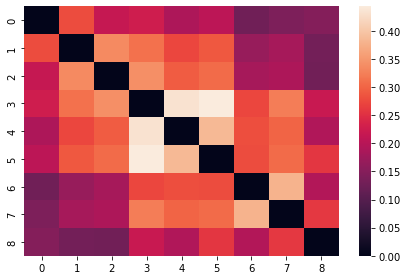

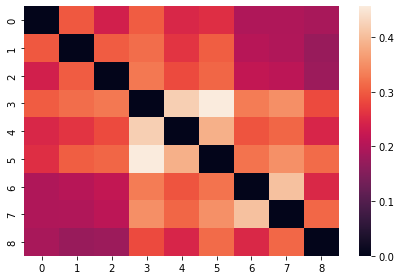

In [31]:
np.fill_diagonal(jacMatrices[40], .7)
print(Data.genescores[0].shape)
print(Data.genescores[1].shape)
drawMatrix(cosMatrices[3])
#print((cosMatrices[17]))
#drawMatrix(jacMatrices[0])
drawMatrix(jacMatrices[2])

In [663]:
print(len(Data.genescores[2]))
print(len(Data.genes[2]))

2375
2375


In [224]:
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from natto.process.kNearestNeighbours import sortDistsAndInds

def multiScaleClusters(nnData, n_components, kFromNeighbors, kFromSame, intraSliceNeighbors, interSliceNeighbors, distanceMetric, distCoeff, sortVar):
    multiscaleClusters = []
    sliceCentroids=[]
    
    ### Clustering each Slice
    print("Clustering time-slices for Multiscale Analysis")
    for i, d in enumerate(nnData):
        centroids=np.empty((0, d.shape[1]), int)
        multiscaleClusters.append(GaussianMixture(n_components=n_components, covariance_type='full', random_state=1337).fit_predict(d))
        for num in range(n_components):
            ### For every cluster find centroid
            centroid =  np.mean(d[np.where(multiscaleClusters[i]==num), :],axis=1)
            #print(centroid)
            centroids=np.vstack((centroids,centroid))
        sliceCentroids.append(np.array(centroids.copy()))
        
        
    ### Match clusters between slices
    print("Matching Clusters")
    for i in range(len(nnData)-1):
        print(i)
        distances = pairwise_distances(sliceCentroids[i], sliceCentroids[i+1])
        rowInd, colInd = linear_sum_assignment(distances) #colInd are the matching clusters from nnData[i+1]
        if i==0:
            matchingClusters=rowInd
        matchingClusters = np.column_stack((matchingClusters,colInd))
    
    
    ### Find Neighbors Based on Matching Clusters
    print("Performing by Cluster Neighbor Approximation")
    if interSliceNeighbors.__name__=='hungarianAll':
        precomputedKNNDistances = np.empty((0, kFromSame+(len(nnData)-1)*kFromNeighbors), int)
        precomputedKNNIndices = np.empty((0, kFromSame+(len(nnData)-1)*kFromNeighbors), int)
    else:
        precomputedKNNDistances = np.empty((0, kFromSame+2*kFromNeighbors), int)
        precomputedKNNIndices = np.empty((0, kFromSame+2*kFromNeighbors), int)
        
    #originalIndices=[]
    print("BEGIN")
    for i in range(n_components):
        #print(matchingClusters[0,:])
        #print(multiscaleClusters[0])
        print(f"Cluster {i}")
       
        sameClusterData = [d[np.where(multiscaleClusters[index] == matchingClusters[i, index])] for index, d in enumerate(nnData)]
        sameClusterIndices = [list(np.where(multiscaleClusters[index] == matchingClusters[i, index])) for index, d in enumerate(nnData)]

        indexStart=0
        for inds, d in zip(range(len(sameClusterIndices)), range(len(nnData))):
            sameClusterIndices[inds]=[j+indexStart for j in sameClusterIndices[inds]]
            indexStart += len(nnData[d])
        sameClusterIndices = np.concatenate(sameClusterIndices, axis=1)[0]

        (tempKNNIndices, tempKNNDistances) = timeSliceNearestNeighbor(sameClusterData, 
                                                                      kFromNeighbors=kFromNeighbors, 
                                                                      kFromSame=kFromSame,
                                                                      intraSliceNeighbors=intraSliceNeighbors,
                                                                      interSliceNeighbors=interSliceNeighbors,
                                                                      distanceMetric=distanceMetric,
                                                                      distCoeff=distCoeff,
                                                                      sort=sortVar,
                                                                      silent=True)
        #print(tempKNNIndices)
                           
        for j, row in enumerate(tempKNNIndices):
            for k, col in enumerate(row):
                tempKNNIndices[j,k] = sameClusterIndices[tempKNNIndices[j,k]]

        precomputedKNNDistances = np.vstack((precomputedKNNDistances, tempKNNDistances))
        precomputedKNNIndices = np.vstack((precomputedKNNIndices, tempKNNIndices))
        
    #Sort outputs first by neighbor distances (smallest to largest) and then by cell number (ascending from 0)
    precomputedKNNIndices, precomputedKNNDistances = sortDistsAndInds(precomputedKNNIndices, precomputedKNNDistances)
    precomputedKNNDistances = precomputedKNNDistances[precomputedKNNIndices[:,0].argsort()]
    precomputedKNNIndices = precomputedKNNIndices[precomputedKNNIndices[:,0].argsort()]
    return precomputedKNNIndices, precomputedKNNDistances


In [52]:
### Calculate NNGraph
from natto.process.kNearestNeighbours import sklearnNN, hungarian, hungarianAll, sklearnNNOG, hungarianOG, hungarianAllOG
whichProjection = 'PCA'
multiscale=False
n_components=5

kFromNeighbors=1
kFromSame=20
intraSliceNeighbors=sklearnNN #['sklearnNN', 'hungarian', 'hungarianAll']
interSliceNeighbors=hungarian #['sklearnNN', 'hungarian', 'hungarianAll']
distanceMetric='normMeans'
distCoeff=1 #Default 1
farPenalty=1
sortVar=True
    
    
t0 = time.time()

###
    
if whichProjection=='PCA' and ('sim' not in datasets) and ('simLarge' not in datasets):
    print("Using PCA")
    nnData = Data.projections[1]
elif whichProjection=='umap':
    print("Using Umap")
    nnData = Data.d10
else:
    if (datasets != 'sim') and (datasets != 'simLarge'):
        nnData = [data.to_df().to_numpy() for data in Data.data]
    else:
        nnData = Data.data
        #pcaObj = PCA(n_comps=10)
        #nnData = pcaObj.fit(nnData)
        
        
print("Computing Nearest Neighbors")
if not multiscale:
    (precomputedKNNIndices, precomputedKNNDistances) = timeSliceNearestNeighbor(nnData, 
    #(precomputedKNNIndices, precomputedKNNDistances) = timeSliceNearestNeighbor(nnData, 
    #sparseMatrix = timeSliceNearestNeighbor(nnData,
                                                                            kFromNeighbors=kFromNeighbors, 
                                                                            kFromSame=kFromSame,
                                                                            intraSliceNeighbors=intraSliceNeighbors,
                                                                            interSliceNeighbors=interSliceNeighbors,
                                                                            distanceMetric=distanceMetric,
                                                                            distCoeff=distCoeff,
                                                                            farPenalty=farPenalty,
                                                                            sort=sortVar)
    '''
    print(type(sparseMatrix))
    print(dir(sparseMatrix))
    print(sparseMatrix.indptr)
    print(sparseMatrix.indices)
    print(sparseMatrix.data)
    precomputedKNNIndices = []
    precomputedKNNDistances = []
    
    for ip in range(len(sparseMatrix.indptr)-1):
        start = sparseMatrix.indptr[ip]
        end = sparseMatrix.indptr[ip+1]
        precomputedKNNIndices.append(sparseMatrix.indices[start:end])
        precomputedKNNDistances.append(sparseMatrix.data[start:end])
        
    precomputedKNNIndices = np.vstack(precomputedKNNIndices)
    precomputedKNNDistances = np.vstack(precomputedKNNDistances)
    '''
else:
    (precomputedKNNIndices, precomputedKNNDistances) = multiScaleClusters(nnData,
                                                                          n_components=n_components,
                                                                          kFromNeighbors=kFromNeighbors, 
                                                                          kFromSame=kFromSame,
                                                                          intraSliceNeighbors=intraSliceNeighbors,
                                                                          interSliceNeighbors=interSliceNeighbors,
                                                                          distanceMetric=distanceMetric,
                                                                          distCoeff=distCoeff,
                                                                          sortVar=sortVar)

### NEIGHBOR_DISTANCE can be 'max', 'median', '3quartile', 'firstKMeans', 'lastKMeans'
### Metric can be 'sklearnNN', 'hungarian', or 'hungarianAll'
    # Note: for non-square matrices use 'nn'
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//60}m")

Using PCA
Computing Nearest Neighbors


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset 0 Complete


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset 1 Complete
Time Elapsed: 0.0m


In [53]:
print(precomputedKNNIndices)
print(precomputedKNNDistances)

print(nnData)

[[   0 1254  466 ...  175  268 1118]
 [   1 1361  399 ...  497  440  809]
 [   2  174  448 ...   29   28  353]
 ...
 [1585  382 1387 ... 1126 1291   47]
 [1586  987  885 ... 1055  932 1249]
 [1587 1007  817 ... 1280 1370 1405]]
[[ 0.         16.56361942 18.91152382 ... 20.76626205 20.83358574
  23.65659542]
 [ 0.          7.74166561  8.19670391 ...  9.57326412  9.61811066
  10.44872212]
 [ 0.         15.17192936 15.76391315 ... 18.07895279 18.11241341
  18.12766838]
 ...
 [ 0.         10.12808272 10.80204391 ... 12.97428322 13.10314846
  14.68810228]
 [ 0.          9.68101597 10.33558655 ... 11.58488464 11.61508751
  11.72555733]
 [ 0.          7.34294748  7.93608236 ...  8.84810638  8.84984112
   8.88290596]]
[array([[-8.538824  , -1.2929488 ,  2.98386   , ...,  2.4459195 ,
         1.2178909 , -4.194738  ],
       [11.602916  , -1.5412655 , -6.600156  , ...,  0.43963698,
        -0.13194872, -0.5940655 ],
       [-3.6624267 ,  1.1486636 ,  0.57623255, ...,  2.3493116 ,
         1.153

In [54]:
# Calculate NNDescent object, Umap, and Transform Data
usePrecomputed = True
useTSNE = False

y=None

t0 = time.time()
if True:
    print(np.vstack(nnData))
    print(np.vstack(nnData).shape)

    if usePrecomputed and not useTSNE:
        print(precomputedKNNIndices.shape)
        print(precomputedKNNDistances.shape)
        print("Computing NNDescent Object")

        pyNNDobject = NNDescent(np.vstack(nnData), metric='euclidean', random_state=1337)
        pyNNDobject._neighbor_graph = (precomputedKNNIndices.copy(), precomputedKNNDistances.copy())
        precomputedKNN = (precomputedKNNIndices, precomputedKNNDistances, pyNNDobject)
        n_neighbors = precomputedKNNIndices.shape[1]
    else:
        precomputedKNN = (None, None, None)
        n_neighbors = 15
    
    if not useTSNE:
        print("Beginning UMAP Projection")
        mymap = UMAP(n_components=2, #Dimensions to reduce to
            n_neighbors=n_neighbors,
            random_state=1337,
            metric='euclidean',
            precomputed_knn=precomputedKNN,
            force_approximation_algorithm=True)

        mymap.fit(np.vstack(nnData), y=y)

        print("Transforming Data")
        transformedData = [mymap.transform(x) for x in nnData]
    
    elif useTSNE:
        from sklearn.manifold import TSNE
        model = TSNE(n_components=2,
             random_state=1337,
             metric='precomputed')
        model.fit(np.vstack(nnData))
        transformedData = [model.transform(x) for x in nnData]



t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//60}m")

[[-8.538824   -1.2929488   2.98386    ...  2.4459195   1.2178909
  -4.194738  ]
 [11.602916   -1.5412655  -6.600156   ...  0.43963698 -0.13194872
  -0.5940655 ]
 [-3.6624267   1.1486636   0.57623255 ...  2.3493116   1.1532465
  -0.05109366]
 ...
 [ 6.583781    1.7895406   3.625771   ... -1.008839   -0.6508552
   2.9443183 ]
 [-5.67113    -1.5470577   1.2638679  ...  0.53643566 -2.3597054
   0.5154134 ]
 [15.038265   -2.083681    2.3465981  ...  1.9516976  -0.17418474
  -1.7455232 ]]
(1588, 40)
(1588, 22)
(1588, 22)
Computing NNDescent Object
Beginning UMAP Projection
Transforming Data
Time Elapsed: 0.0m


Predicting Gaussian Labels
Calculating Louvain Labels


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Length of Labels: 4
Length of Data to Draw: 4
(2, 2)
[794, 794, 794, 794]


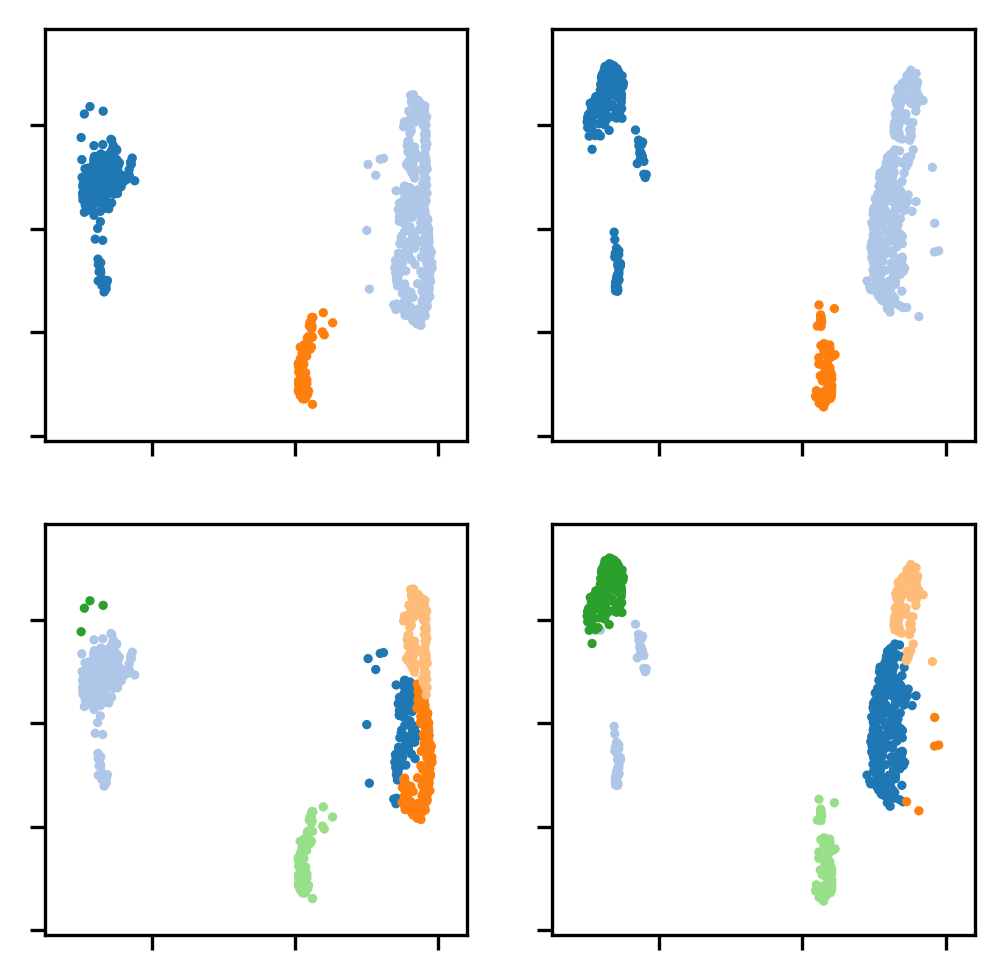

Total time elapsed: 0.0s


In [55]:
t0 = time.time()
predictLabels = True

ARITableDict = {}
doARI = False
drawData = []
drawLabels=[]
method = ['GMM', 'Louvain'] # 'True Labels', GMM', 'Louvain', 'leiden', 'DBSCAN', 'HDBSCAN', 'natto'
make_even=False

#if doARI:
    #ARIdf = pd.DataFrame(index=method[1:-1] ,columns=[])

if Labels==None or predictLabels==True:
    ### Predict the labels of our transformed data

    transformedDataStack = np.vstack(transformedData)
    indicesColumn = np.asarray([(index+1)/(1*(len(Data.data))) for index, dataSlice in enumerate(nnData) for dataPoint in dataSlice]).reshape(-1,1)
    transformedDataStack = np.hstack([transformedDataStack, indicesColumn])
    

    tempData = [x.copy() for x in transformedData]
    if Labels is not None:
        tempLabels = [y.copy() for y in Labels]
    ### Performs function to get Labels
    if 'True Labels' in method and Labels is not None:
        print("Preparing Real Labels")
        for index in range(len(tempLabels)):
            #tempLabels[index][np.isnan(tempLabels[index])] = -1
            tempLabels[index] = [int(x) for x in tempLabels[index]]
            #tempData[index] = tempData[index][np.asarray(tempLabels[index]) != -1]
            tempData[index] = AnnData(tempData[index])
        #tempLabels = [[label for label in labels if label != -1 ] for labels in tempLabels]
        
        for index,a in enumerate(tempData):
            tempData[index].obs['labels'] = tempLabels[index]
        for label in tempLabels:
            print(set(list(label)))
            
        
        for index, data in enumerate(tempData):
            print(data.shape)
            
            
        ### Make_even
        if make_even:
            counts = [e.shape[0] for e in tempData]
            smallest = min(counts)
            for i,a in enumerate(tempData):
                if a.shape[0] > smallest:
                    subsample(tempData[i],
                                    fraction=None,
                                    n_obs=smallest,
                                    random_state=0,
                                    copy=False)
                print(a.shape)
        
        
        
        stackedLabels = np.hstack([x.obs['labels'] for x in tempData]).flatten()
        #print(stackedLabels[0])
        print(stackedLabels.shape)
        tempLabels = [list(x.obs['labels']) for x in tempData]
        tempData = [x.to_df().to_numpy() for x in tempData]    
        #print(f"TempData: {[d.shape for d in tempData]}, tempLabels: {list(l).shape for l in tempLabels}")
        #print(tempLabels)

        drawData += tempData
        drawLabels += tempLabels

        
    ### Gets correct indices for each set of labels
    sumToAdd = 0
    #print(tempData)
    shapes = [x.shape[0] for x in tempData]
    #shapes = [x.shape[0] for x in Data.data]
    for index in range(len(shapes)):
        shapes[index] += sumToAdd
        sumToAdd = shapes[index]
    dataIndices = [0] + shapes

    
    if 'GMM' in method:
        print("Predicting Gaussian Labels")
        n_components=3
        #labels2D = GaussianMixture(n_components=n_components, covariance_type='full', random_state=1337).fit_predict(transformedDataStack)
        labels2D = GaussianMixture(n_components=n_components, covariance_type='full', random_state=1337).fit_predict(np.vstack(tempData))
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
        #tempData = transformedData.copy()
        
        if Labels is not None and doARI:
            ARITableDict['GMM'] = []
            print(stackedLabels)
            
            ARITableDict['GMM'].append(ARI(stackedLabels, [item for sublist in labels2D for item in sublist]))
            ARITableDict['GMM'].append(np.mean([ARI(tempLabels[i], labels2D[i]) for i in range(len(Labels))]))
            if Labels is not None:
                for index, l in enumerate(Labels):
                    print(f"ARI:{index} {ARI(tempLabels[index], labels2D[index])}")
                    ARITableDict['GMM'].append(ARI(tempLabels[index], labels2D[index]))
                print(f"Average ARI = {np.mean([ARI(tempLabels[i], labels2D[i]) for i in range(len(Labels))])}")
                print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labels2D for item in sublist])}")
        drawData += tempData
        drawLabels += labels2D
        
                
    if 'Louvain' in method:
        from scanpy.tl import louvain
        print("Calculating Louvain Labels")

        #transformedAnnData = AnnData(transformedDataStack, obs=pd.DataFrame(indicesColumn).astype('str'))
        transformedAnnData = AnnData(np.vstack(tempData), obs=pd.DataFrame(indicesColumn).astype('str'))
        neighbors(transformedAnnData)
        louvain(transformedAnnData, resolution=0.07, random_state=1337)
        labels2D = transformedAnnData.obs['louvain'].tolist()
        labels2D = [int(x) for x in labels2D]
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
        
        if Labels is not None and doARI:
            ARITableDict['Louvain'] = []
            ARITableDict['Louvain'].append(ARI(stackedLabels, [item for sublist in labels2D for item in sublist]))
            ARITableDict['Louvain'].append(np.mean([ARI(tempLabels[i], labels2D[i]) for i in range(len(Labels))]))

            for index, l in enumerate(Labels):
                print(f"ARI:{index} {ARI(tempLabels[index], labels2D[index])}")
                ARITableDict['Louvain'].append(ARI(tempLabels[index], labels2D[index]))
            print(f"Average ARI = {np.mean([ARI(tempLabels[i], labels2D[i]) for i in range(len(Labels))])}")
            print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labels2D for item in sublist])}")

        tempData = transformedData.copy()
        drawData += tempData
        drawLabels += labels2D

        
    if 'leiden' in method:
        from scanpy.tl import leiden
        transformedAnnData = AnnData(transformedDataStack, )
        print("Calculating Leiden Labels")
        neighbors(transformedAnnData)
        leiden(transformedAnnData, resolution=0.12, random_state=1337)
        labels2D = transformedAnnData.obs['leiden'].tolist()
        labels2D = [int(x) for x in labels2D]
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
    
        if Labels is not None:
            for index, l in enumerate(Labels):
                print(f"ARI:{index} {ARI(Labels[index], labels2D[index])}")
            print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labels2D for item in sublist])}")

        tempData = transformedData.copy()
        drawData += tempData
        drawLabels += labels2D

        
    if 'DBSCAN'in method:
        from sklearn.cluster import DBSCAN
        print("Performing DBSCAN Clustering")
        labels2D = list(DBSCAN(eps=0.15, min_samples=10).fit(transformedDataStack).labels_)
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]

        if Labels is not None:
            print(f"ARI: {ARI(stackedLabels, [item for sublist in labels2D for item in sublist])}")

        tempData = transformedData.copy()
        drawData += tempData
        drawLabels += labels2D       

    
    if 'HDBSCAN' in method:
        from hdbscan import HDBSCAN
        print("Performing HDBSCAN Clustering")
        labels2D = list(HDBSCAN(min_cluster_size=25, min_samples=25, alpha=1.8).fit(transformedDataStack).labels_)
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
        print(set(labels2D[0]))

        tempData = transformedData.copy()
        drawData += tempData
        drawLabels += labels2D
    
    if 'KMeans' in method:
        from sklearn.cluster import KMeans
        print("Performing KMeans Clustering")
        labels2D = list(KMeans(n_clusters=18).fit(transformedDataStack).labels_)
        labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
        if Labels is not None:
            for index, l in enumerate(Labels):
                print(f"ARI:{index} {ARI(Labels[index], labels2D[index])}")
            print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labels2D for item in sublist])}")

        
        tempData = transformedData.copy()
        drawData += tempData
        drawLabels += labels2D
    
    if 'natto' in method:
        print("Performing Natto Clustering")
        #labels2D = cluster.gmm_1(transformedData[0])
        labels2D = cluster.gmm_1(tempData[0])
        #print(transformedData)
        print([d.shape for d in tempData])
        #print([l.shape for l in labels2D])
        labels2D, e, labels, probas = k2means.multitunnelclust((tempData), labels2D, method='full')
        ### 'full', 'diag', 'tied'
        labels2D[e] = -1

        if Labels is not None:
            print(f"ARI: {ARI(stackedLabels, [item for sublist in labels for item in sublist])}")

        #tempData = transformedData.copy()
        drawData += tempData
        #drawLabels += [labels2D]*(len(transformedData))
        drawLabels += labels


#        print(drawLabels)
    #rows = (len(drawLabels)//len(Data))
#    drawData = np.tile(transformedData, (rows,1,1))

else:
    ### Labels already provided
    tempData = transformedData.copy()
    drawData += tempData

    Labels = [np.nan_to_num(x, nan=-1.0).astype(int) for x in Labels]
    drawLabels += Labels

#print(drawLabels)
print(f"Length of Labels: {len(drawLabels)}")
#transformedData = [transformedData[k*len(Data[k]):(k+1)*len(Data[k]),0:2] for k in range(0,len(Data))]
    #drawData 
#print(drawData)
print(f"Length of Data to Draw: {len(drawData)}")


dim = (len(drawLabels)//len(Data.data), len(Data.data))
print(dim)
print([np.asarray(x).shape[0] for x in drawData])
#importlib.reload(draw)
if datasets=='rawMouseCortex':
    xtitles = ['Day 11', 'Day 13', 'Day 15', 'Day 17']
elif datasets == 'MouseCerebellum':
    xtitles = ['E10','E12','E14','E16','E18','P0','P5','P7','P14']
elif datasets == 'sim' or datasets=='simLarge':
    xtitles = ['Time 0', 'Time 1','Time 2', 'Time 3', 'Time 4']
#xtitles = [f'time {t}' for t in range(dim[1])]
ytitles = ['']
#ytitles = ['\nTrue\nLabels', '\nGMM\nLabels', '\nLouvain\nLabels', '\nNatto\nLabels']
draw.auto_tiny(drawData, drawLabels, wrap='test', dim=dim, same_limit=True, xtitles=None, ytitles=None, legend=False, save=False, save_name=f'Sim5_GMMClustering.png')
t1 = time.time()

if doARI:
    print(ARITableDict)
    print(pd.DataFrame(ARITableDict.values(), index=ARITableDict.keys(), columns = ['Together', 'Mean']+xtitles))
print(f"Total time elapsed: {(t1-t0)//1}s")


In [553]:
### Find Max ARI
method = 'louvain'
if method=='gauss':
    values = range(1,30)
    scores=[]
    for n in values:
        labels2D = GaussianMixture(n_components=n, covariance_type='full', random_state=1337).fit_predict(np.vstack(tempData))
        #labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
        score = ARI(stackedLabels, labels2D)
        scores.append(score)
        print(f"{n}:{score}")
elif method=='louvain':
    #values = [2,1.5,1,0.8,0.5,0.15,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.0000001,0.0000000001]
    values = [0.14,0.13,0.12,0.11,0.1,0.09,0.08,0.07,0.06,0.05,0.04]
    #values = [0.03, 0.02,0.01,0.009,0.008,0.007,0.006]
    scores = []
    for n in values:
        transformedAnnData = AnnData(np.vstack(tempData), obs=pd.DataFrame(indicesColumn).astype('str'))
        neighbors(transformedAnnData)
        louvain(transformedAnnData, resolution=n, random_state=1337)
        labels2D = transformedAnnData.obs['louvain'].tolist()
        score = ARI(stackedLabels, labels2D)
        scores.append(score)
        print(f"{n}: {score}")

print("")
print(scores)
bestIndex = np.argmax(scores)
print(f"Top Score = {scores[bestIndex]} for n Clusters {values[bestIndex]}")


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.14: 0.42351739235353664


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.13: 0.42351739235353664


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.12: 0.4610947142971437


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.11: 0.4610947142971437


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.1: 0.4861238095685383


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.09: 0.4725595046185042


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.08: 0.4725595046185042


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.07: 0.5083653615331852


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.06: 0.44702486879332737


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.05: 0.44702486879332737


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.04: 0.4318109077852486

[0.42351739235353664, 0.42351739235353664, 0.4610947142971437, 0.4610947142971437, 0.4861238095685383, 0.4725595046185042, 0.4725595046185042, 0.5083653615331852, 0.44702486879332737, 0.44702486879332737, 0.4318109077852486]
Top Score = 0.5083653615331852 for n Clusters 0.07


IndexError: list index out of range

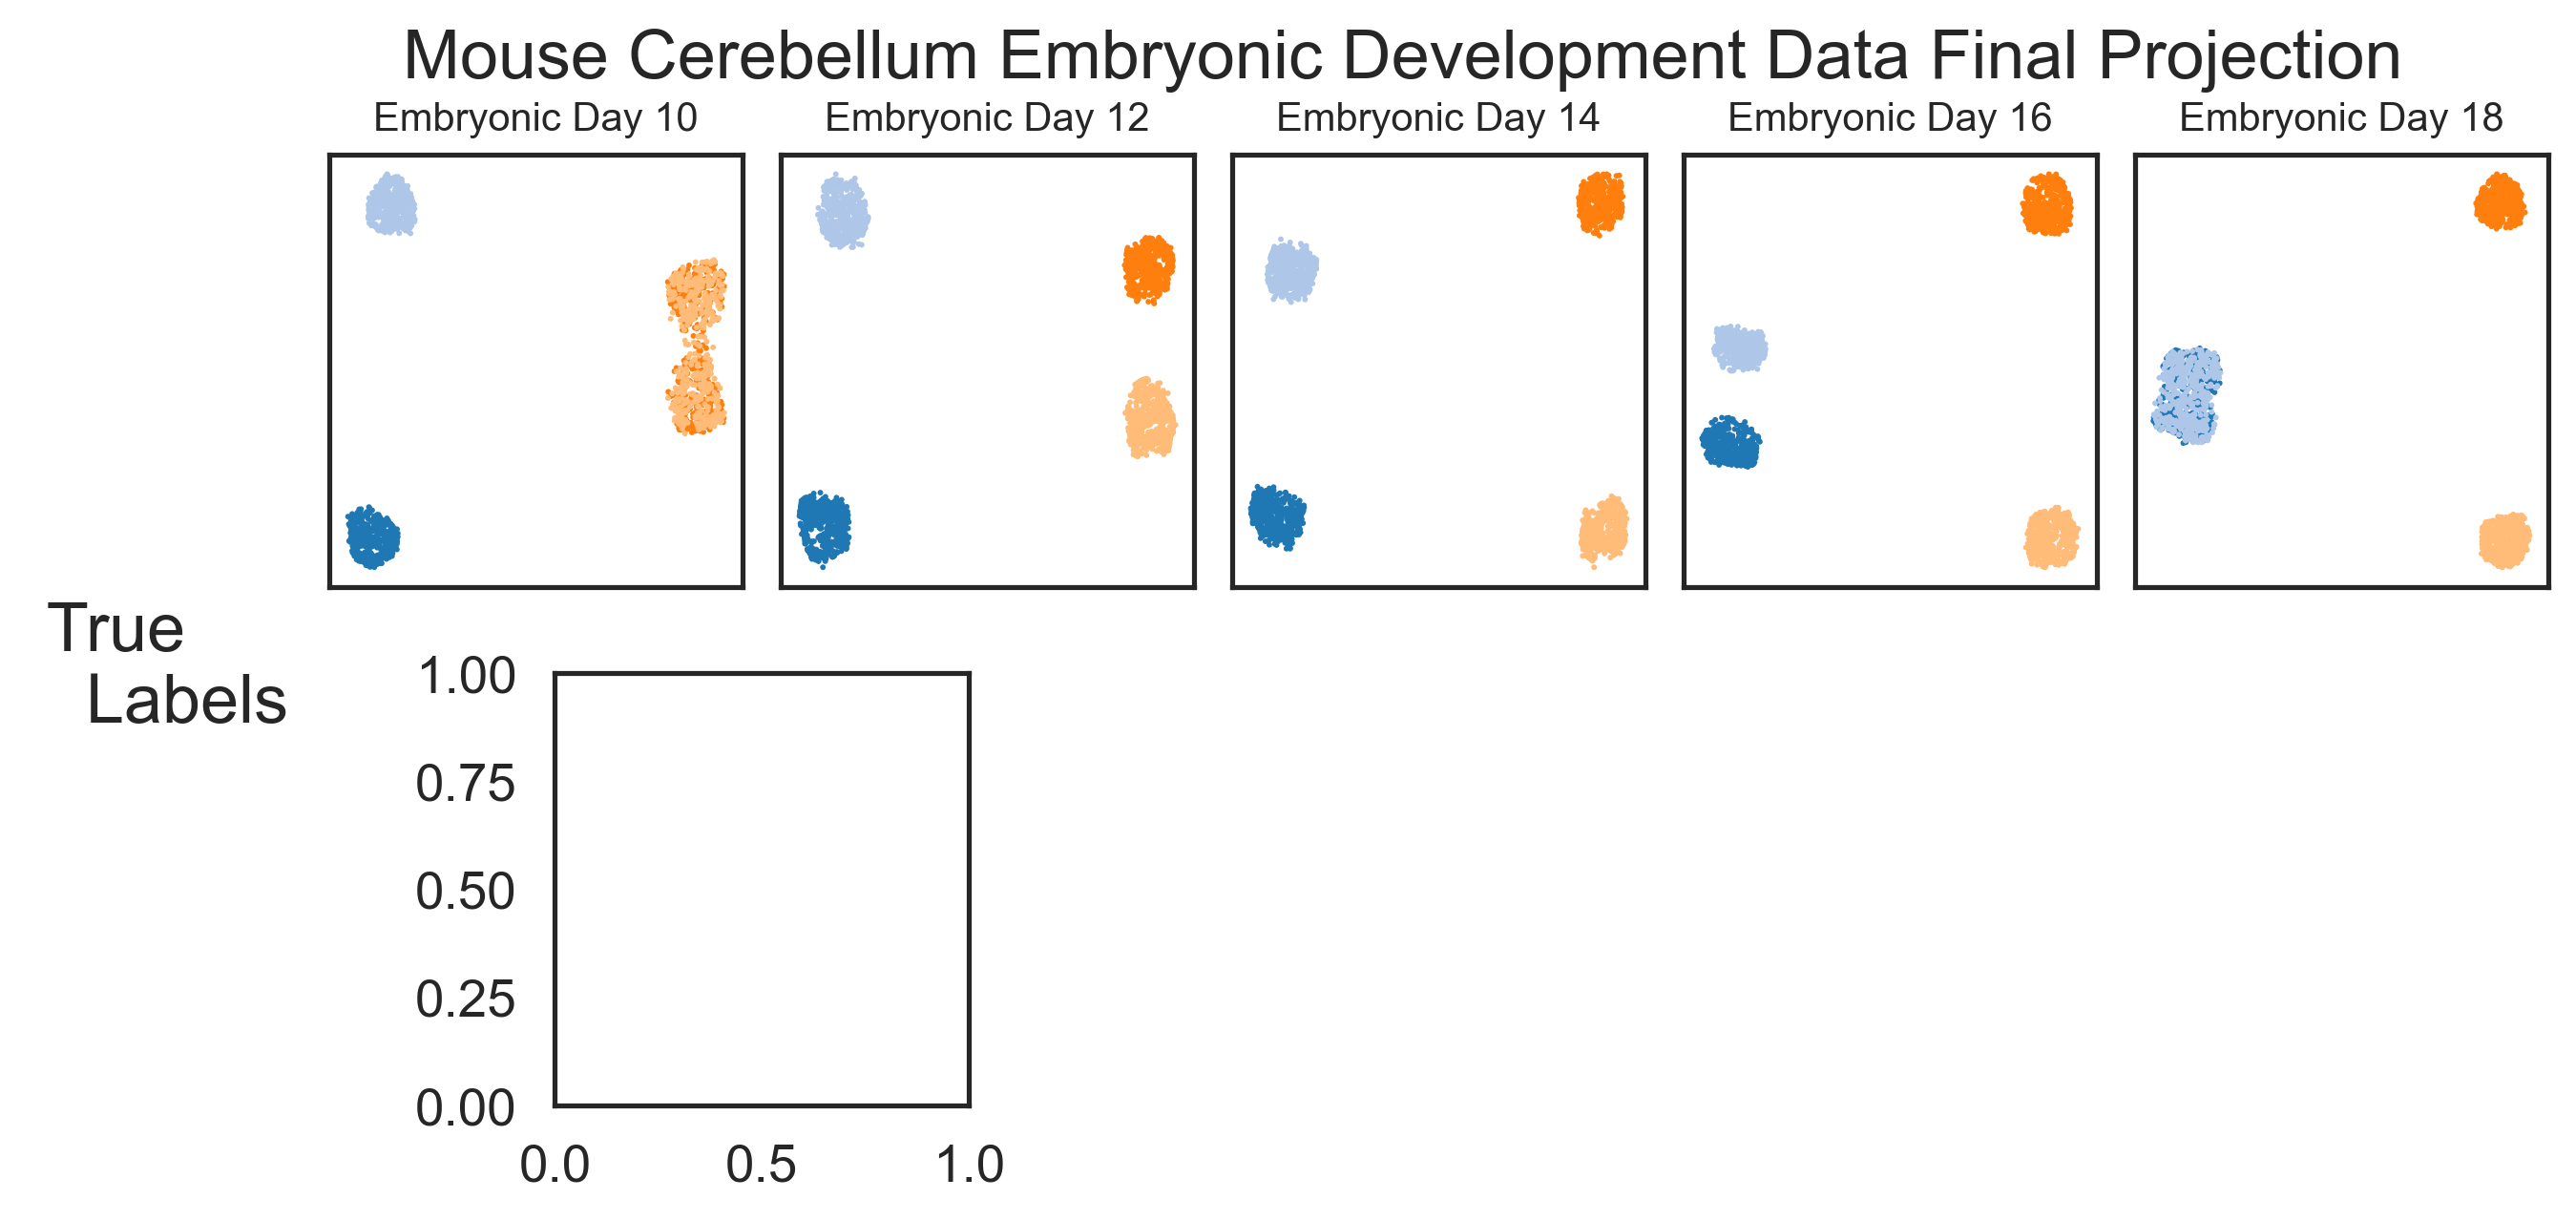

In [425]:
## Plot Mouse Cerebellum Really Nice
save = False
projection = 'Final' #'Standard' or 'Final'
method = 0 #0,1,2

import matplotlib.gridspec as gridspec
dim = [2,5]
lenPerSection = 9
if method==0:
    fig = plt.figure(figsize=(2*dim[1], 2*dim[0]+0.4), dpi=300)
else:
    fig = plt.figure(figsize=(2*dim[1], 2*dim[0]), dpi=300)
#fig = plt.figure(figsize=(3, 3), dpi=300)
gs = gridspec.GridSpec(2, 10)

if method==0:
    fig.suptitle(f'Mouse Cerebellum Embryonic Development Data {projection} Projection')
ytitles = ['\n True\n   Labels', '\n GMM\n   Labels', '\nLouvain\n   Labels']
fig.supylabel(ytitles[method], rotation='horizontal')

#titles = [f'time {t}' for t in range(9)]
titles = ['Embryonic Day 10', 'Embryonic Day 12', 'Embryonic Day 14', 'Embryonic Day 16', 'Embryonic Day 18',
          'Post-Natal Day 0', 'Post-Natal Day 5', 'Post-Natal Day 7', 'Post_Natal Day 14']

for i in range(0, 9):
    ytitle=None
    if i < 5:
        if i==0: ytitle = ytitles[0]
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        if i==5: ytitle = ytitles[1]
        ax = plt.subplot(gs[1, 2 * i - 9:2 * i + 2 - 9])
    #sc.pp.calculate_qc_metrics(Data[i], percent_top=None, log1p=False, inplace=True)
    #ax.set_title(f"{titles[i]} minutes")
    #sc.pl.violin(Data[i], ['total_counts'], jitter=6, show=False, ax=ax)
    draw.tinyumap(drawData[i+method*lenPerSection], drawLabels[i+method*lenPerSection], title=titles[i])
    #ax.plot()


    #df.plot('x', 'y', ax=ax)
plt.tight_layout()
methodNames = ['True', 'GMM', 'Louvain']
if save:
    fig.savefig(f"MouseCerebellum{projection}Clust{methodNames[method]}.png") 
plt.show()

\###### Baseline
u= UMAP(n_components=2)
u.fit(np.vstack(Data.data))
pdata = [u.transform(a) for a in Data.data]

#pdata = [UMAP().fit_transform(a) for a in Data.data]

labels = cluster.gmm_1(pdata[0], nc=30)
labels, e, labels, probas = k2means.multitunnelclust(list(pdata), labels, method='full')


draw.auto_tiny(pdata, labels, wrap='test', dim=dim)

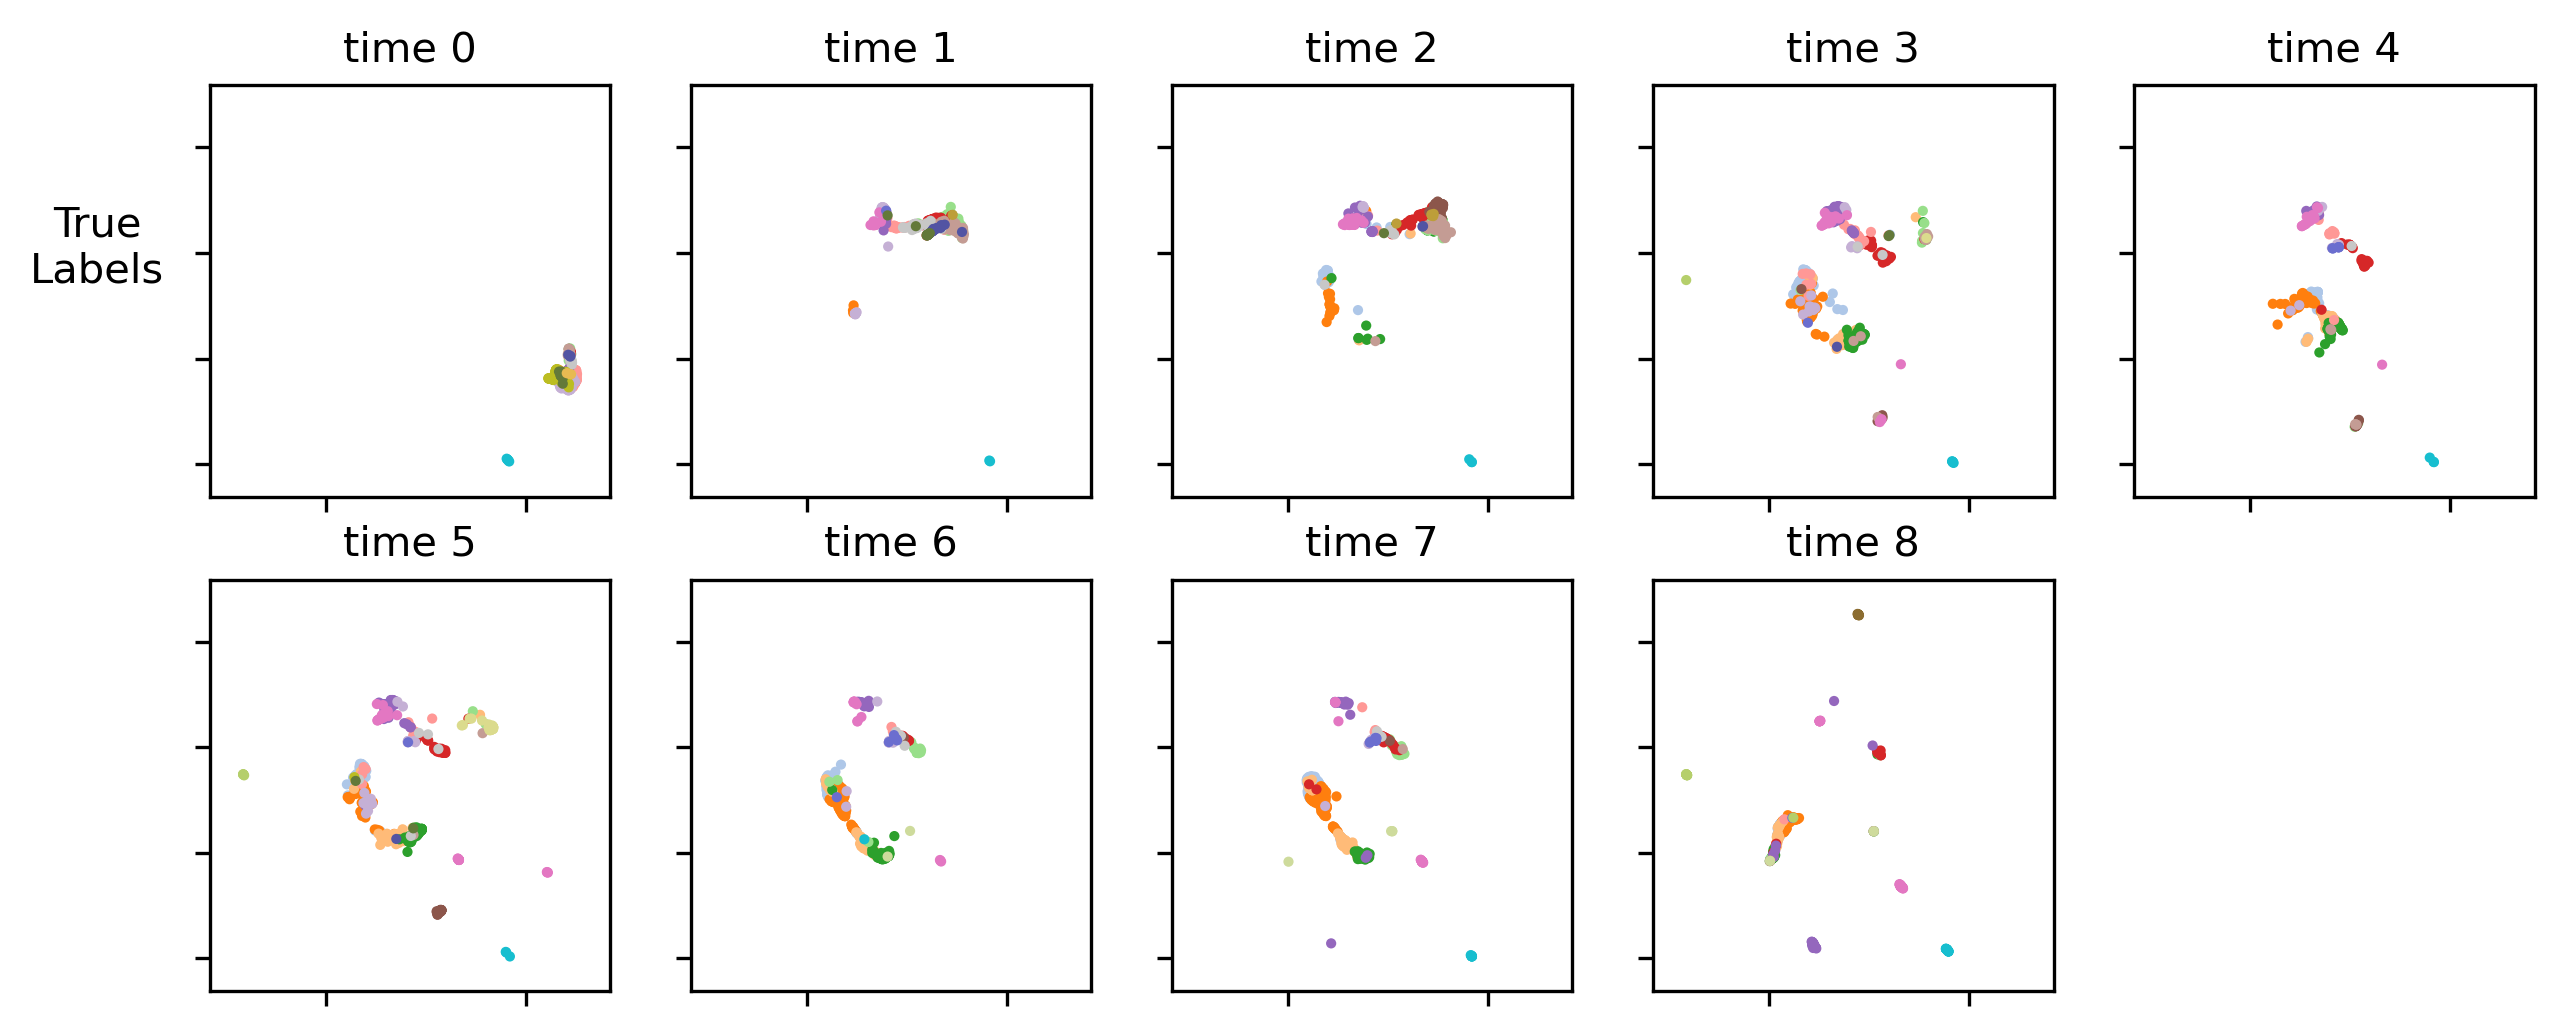

In [43]:
dim=(2,5)
xtitles = [f'time {t}' for t in range(dim[1])]
ytitles = ['\nTrue\nLabels']#, '\nGMM\nLabels', '\nLouvain\nLabels']
xtitles=[f'time {t}' for t in range(9)]
ytitles=['\nTrue\nLabels','']
draw.auto_tiny(drawData[:9], drawLabels[:9], wrap='test', dim=dim, same_limit=True, xtitles=xtitles, ytitles=ytitles, titleAll=True, legend=False, save=False, save_name=f'distCoeff{distCoeff}.png')



3


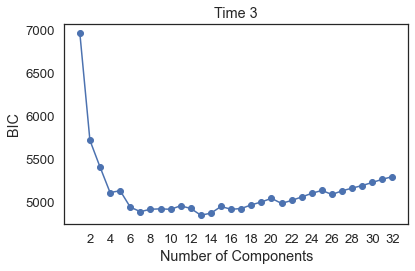

Best num Clusters is 6

GaussianMixture(n_components=6, random_state=1337)
2


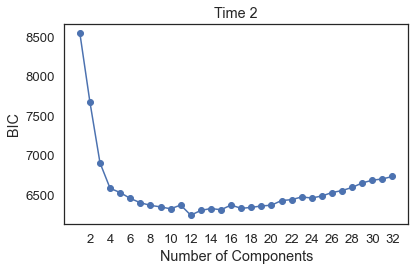

Best num Clusters is 6

GaussianMixture(n_components=6, random_state=1337)
1


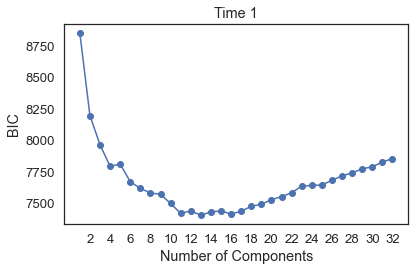

Best num Clusters is 11

GaussianMixture(n_components=11, random_state=1337)
0


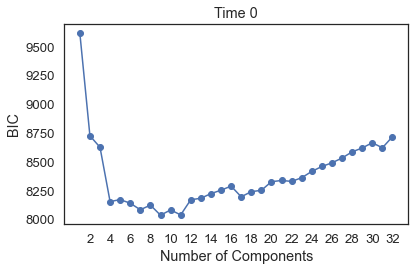

Best num Clusters is 4

GaussianMixture(n_components=4, random_state=1337)

All Mins Found


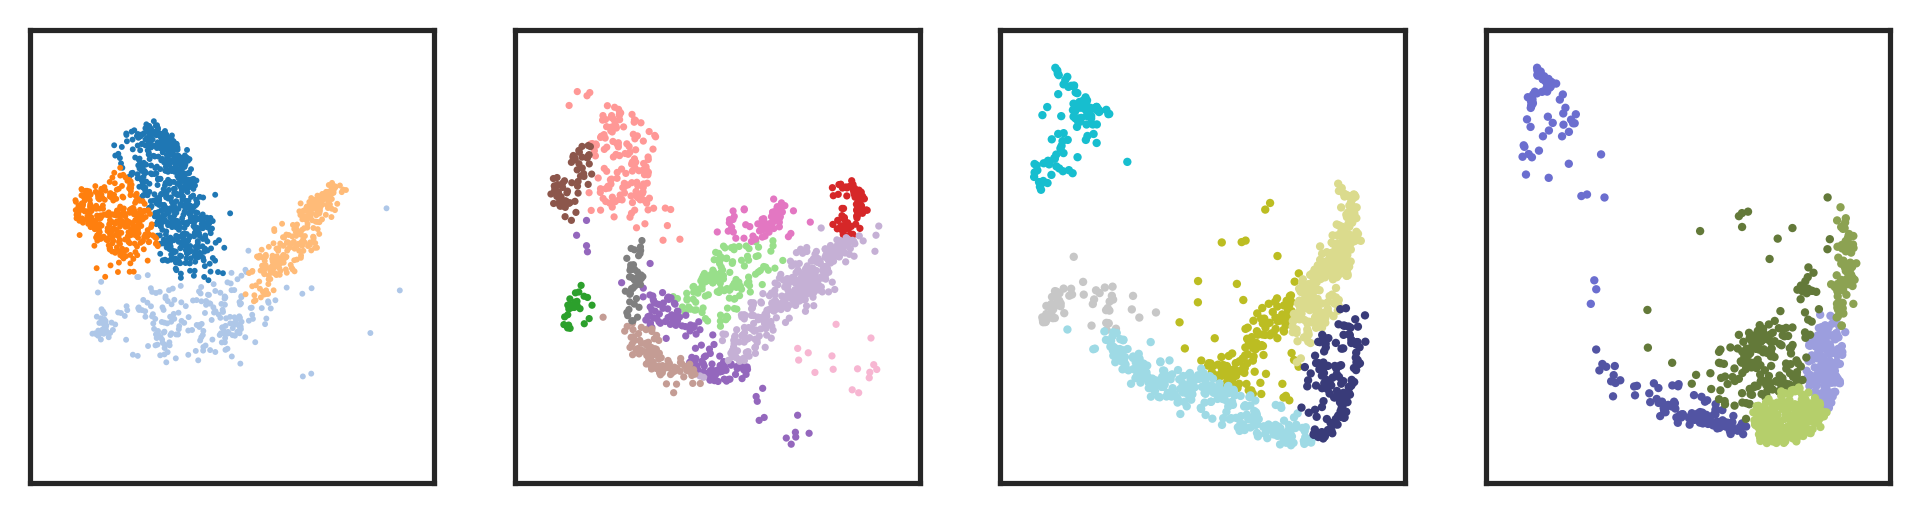

ARI:0 0.554017028068732
ARI:1 0.33753406713976003
ARI:2 0.5353844430465443
ARI:3 0.36756512946180553


In [54]:
### Try makingProgram to observe splitting of clusters
'''
1) Cluster our cells using GMM after UMAP projeciton
2) Find the optimal # of clusters for each slice using BIC
3) See when # of clusters increases
4) Perhaos take the means of these clusters at each slice and try to charectorize how they change
'''
from kneed import KneeLocator
import ubergauss as ug

tempData = [x.copy() for x in transformedData]
tempDataStacked = np.vstack(tempData)

maxClust = 32
nComponentsList=range(1,maxClust+1)

currentMax = maxClust
minBICs = [np.inf]*len(tempData)
minNumComponents = [np.nan]*len(tempData)
bestLabels = [None]*len(tempData)

save=True
saveName='Sim5BIC'
methodOfOptBIC = 'uber' #'uber' or 'kneed' or 'minAdjBIC'

titles = ['Time 0', 'Time 1', 'Time 2', 'Time 3', 'Time 4', 'Time 5']
for i in range(len(tempData)-1, -1, -1):
    print(i)
    d = tempData[i]
    #models = [GaussianMixture(n_components=n, covariance_type='full', random_state=1337).fit(tempDataStacked) for n in nComponentsList]
    models = [GaussianMixture(n_components=n, covariance_type='full', random_state=1337).fit(d) for n in nComponentsList]
    
    bic = [m.bic(d) for m in models]
    
    
    plt.plot(nComponentsList[:maxClust], bic[:maxClust], '-o')
    plt.title(f'{titles[i]}')
    plt.xlabel("Number of Components")
    plt.ylabel("BIC")
    plt.xticks([el for el in nComponentsList[:maxClust] if el%2==0], [el for el in nComponentsList[:maxClust] if el%2==0])
    plt.tight_layout()
    if save:
        plt.savefig(f'{saveName}_{i}.png')
    plt.show()

    if methodOfOptBIC=='kneed':
        kn = KneeLocator(nComponentsList, bic ,curve='convex', direction='decreasing')
        kn.plot_knee_normalized()
        bestNumClusters = kn.knee
        print(bestNumClusters)
        bestBICIndex = nComponentsList.index(bestNumClusters)
        print(bestBICIndex)
    elif methodOfOptBIC == 'uber':
        bestBICIndex = ug.diag_maxdist(bic[:maxClust])
        #plt.scatter(nComponentsList[:maxClust], bic[:maxClust])
        #plt.show()
        #maxClust = bestBICIndex+3
    elif methodOfOptBIC == 'minAdjBIC':
        #bic = [b + (np.log(n)*(len(tempData))) for b,n in zip(bic, nComponentsList)]
        bic = [b for b,n in zip(bic, nComponentsList)]
        bic=bic[:maxClust]
        print(bic)
        bestBICIndex = np.argmin(bic)
        print(bestBICIndex)
        maxClust = bestBICIndex+1
    print(f"Best num Clusters is {nComponentsList[bestBICIndex]}\n")
    print(models[bestBICIndex])
    bestLabels[i] = models[bestBICIndex].predict(d)
                
print("")
print("All Mins Found")

#bestLabels = list(reversed(bestLabels))
numToAdd=0
for i,l in enumerate(bestLabels):
    bestLabels[i] = np.asarray([x+numToAdd for x in bestLabels[i]])
    numToAdd = max(bestLabels[i])+1
draw.auto_tiny(tempData, bestLabels, wrap='test', legend=False, dim=(1,len(tempData)), same_limit=True)

for i,l in enumerate(bestLabels):
    if Labels is not None:
        print(f"ARI:{i} {ARI(Labels[i], l)}")
    
    

In [26]:
### Calc Cluster Centres
### This is then used to match main clusters before finding pairings 
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

def getClusterCentres(labels, data):
    ### Find centres of each cluster
    clusterCentres = [{} for i in range(len(labels))]
    for i, (l,d) in enumerate(zip(labels, data)):
        for n in np.unique(l):
            dMean = np.mean(d[np.where(l==n)[0]], axis=0)
            clusterCentres[i][n]=list(dMean)
    return clusterCentres

def dataToPlot(clusterCentres):
    ### Gets all clusterCentres into big 2Darray
    ### Also saves col (color) for each time point
    col = []
    toShow = np.empty((0,2), dtype=float)
    for i,d in enumerate(clusterCentres):
        v = np.vstack(list(d.values()))
        col = col + [i]*len(v)
        toShow=np.vstack((toShow,v))  
    return col, toShow

def getHung(d1,d2):
    X=[np.vstack(list(d.values())) for d in [d1,d2]]
    indices,distances=util.hungarian(X[0],X[1])
    return indices, distances, X

def plotArrows(clusterCentres):
    for i in range(len(clusterCentres)-1):
        d1=clusterCentres[i]
        d2=clusterCentres[i+1]
        (r, c),distances,X=getHung(d1,d2)
        for j,k in zip(r,c):
            plt.arrow(X[0][j][0], X[0][j][1], X[1][k][0]-X[0][j][0], X[1][k][1]-X[0][j][1], length_includes_head=True,
              head_width=0.08, head_length=0.2, color='black')



clusterCentres = getClusterCentres(bestLabels, tempData)

col, toShow = dataToPlot(clusterCentres)
scatter = plt.scatter(toShow[:,0], toShow[:,1], c=col, s=60, cmap='spring')
plotArrows(clusterCentres)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=range(len(tempData)),
           title="Time Point")
plt.show()

NameError: name 'bestLabels' is not defined

In [33]:
### Preliminary realignment

def prelimAlign(d1, d2, Y2):
    ### Use hungarian to at least make main clusters have the
    ### same labels across time

    (r,c),distances,X=getHung(d1,d2)
    
    d1Keys = list(d1.keys())
    d2Keys = list(d2.keys())
    D1Clusters=[d1Keys[r[index]] for index in range(len(r))]
    D2Clusters=[d2Keys[c[index]] for index in range(len(c))]
    
    #D1Clusters=[]
    #D2Clusters=[]
    #for index in range(len(r)):
        #print(f"replacing: {d2Keys[c[index]]} with {d1Keys[r[index]]}")
        #D1Clusters.append(d1Keys[r[index]])
        #D2Clusters.append(d2Keys[c[index]])
    

    transformationDict = {k2:D1Clusters[i] for i, k2 in enumerate(D2Clusters)}
    #for i, k2 in enumerate(D2Clusters):
        #transformationDict[k2] = D1Clusters[i]
    for k2 in d2.keys():
        if k2 not in transformationDict.keys() and k2 not in D1Clusters:
            transformationDict[k2]=k2
        elif k2 not in transformationDict.keys() and k2 in D1Clusters:
            transformationDict[k2]=max(D2Clusters)+2
    print(transformationDict)

    #Actually replaces the values
    Y2 = np.asarray([transformationDict[y] for y in Y2])
    return Y2

earlyAlignMethod = 'cellsaw'
if earlyAlignMethod == 'cellsaw':
    from cellsaw.merge.draw import confuse
    for i in range(len(tempData)-1):
        y1, y2 = confuse(bestLabels[i].copy(), bestLabels[i+1].copy())
        print(y1)
        print(y2)
        bestLabels[i+1] = y2
        
elif earlyAlignMethod == 'prelim':
    for i in range(len(clusterCentres)-1):
        labels1 = bestLabels[i].copy()
        labels2 = bestLabels[i+1].copy()

        #labels2 = prelimAlign(clusterCentres[i], clusterCentres[i+1], labels2)
        bestLabels[i+1] = prelimAlign(clusterCentres[i], clusterCentres[i+1], bestLabels[i+1])

        #print(labels2)


KeyError: 30

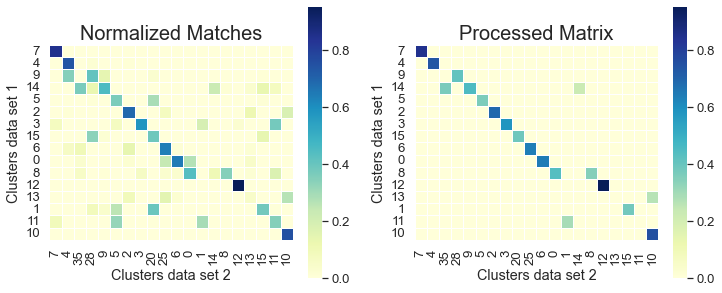

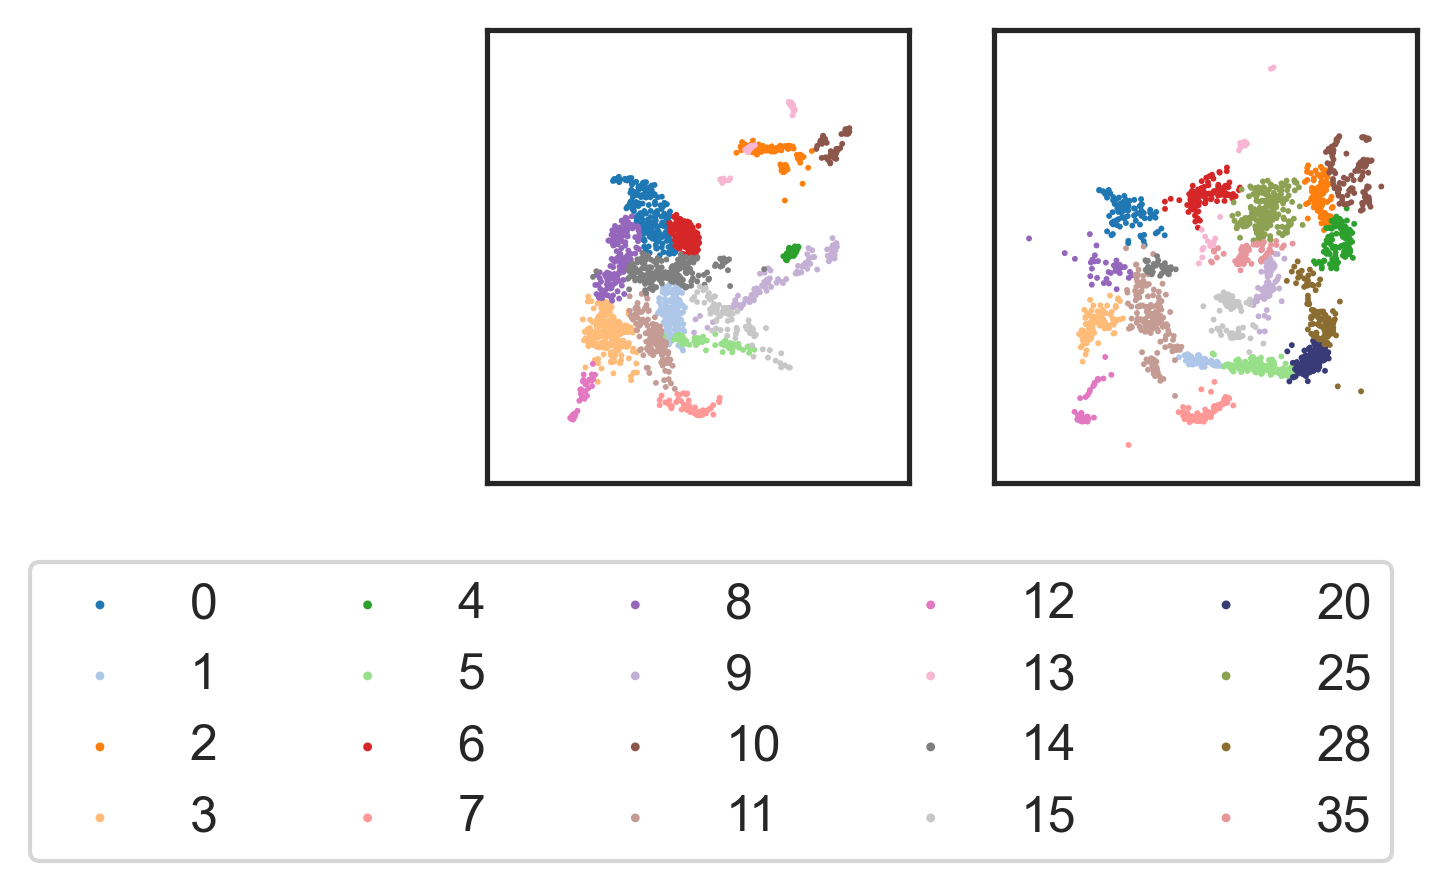

{7: [7], 4: [4], 9: [28], 14: [35, 9, 14], 5: [5], 2: [2], 3: [3], 15: [20], 6: [25], 0: [6], 8: [0, 8], 12: [12], 13: [10], 1: [15], 11: [1], 10: [10]}


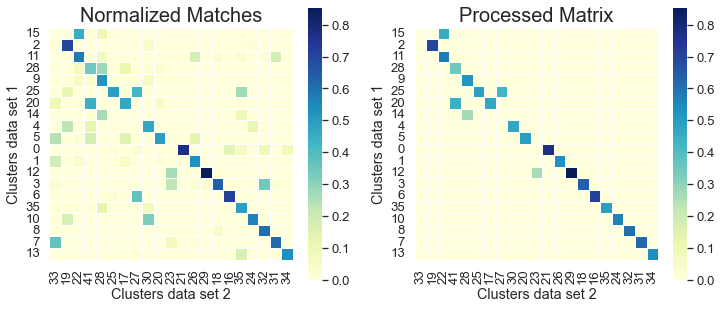

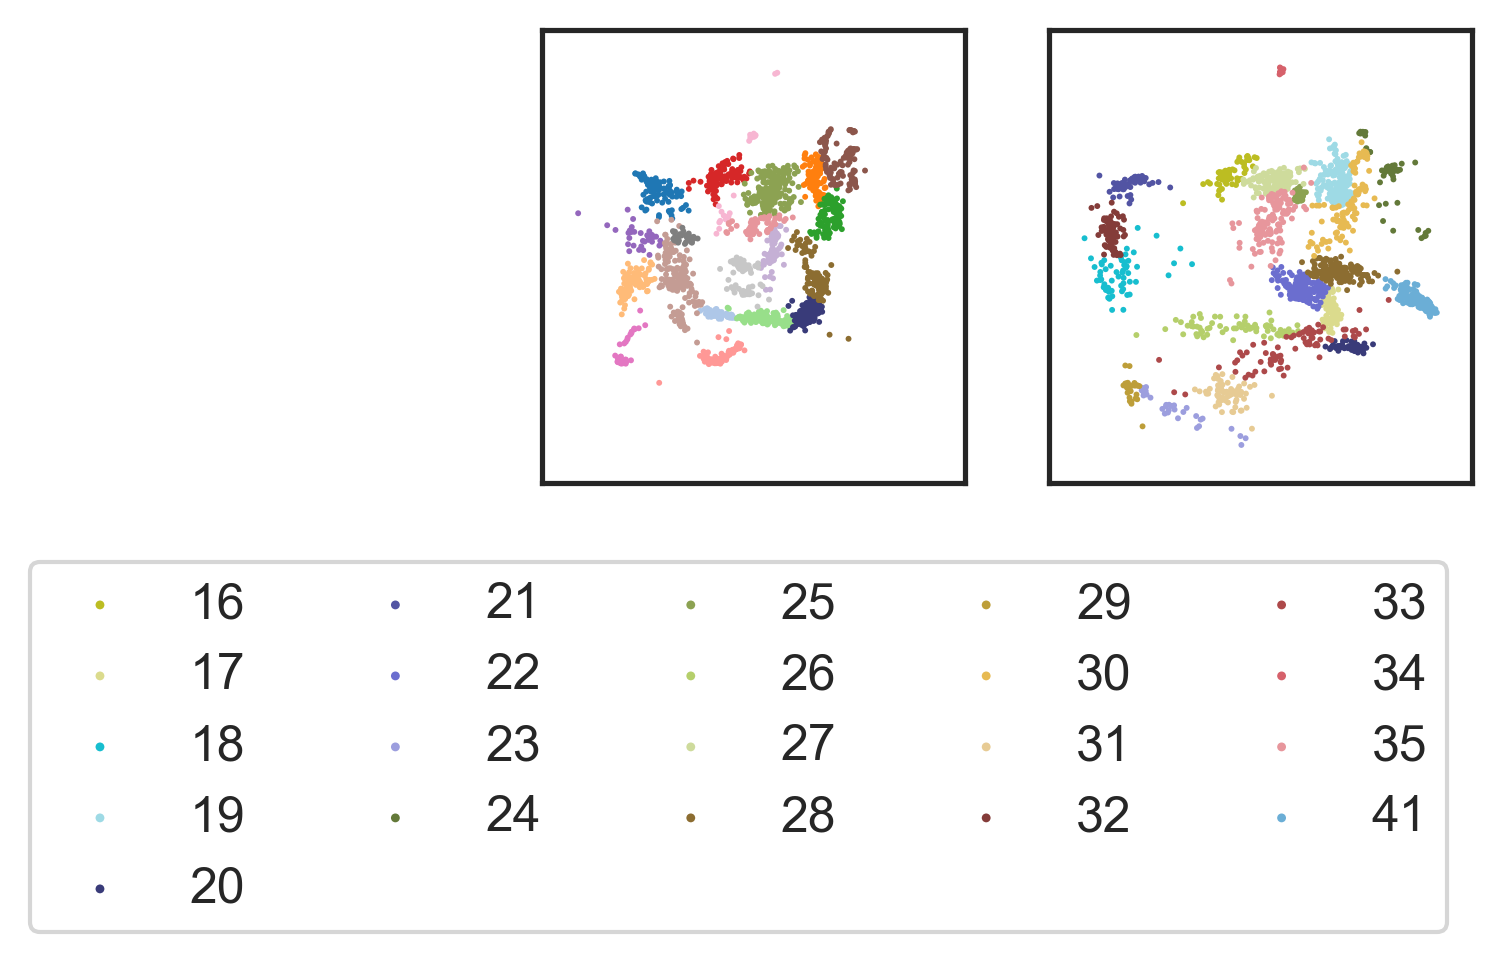

{15: [22], 2: [19], 11: [22], 28: [41], 9: [28], 25: [25, 27], 20: [41, 17], 14: [28], 4: [30], 5: [20], 0: [21], 1: [26], 12: [23, 29], 3: [18], 6: [16], 35: [35], 10: [24], 8: [32], 7: [31], 13: [34]}


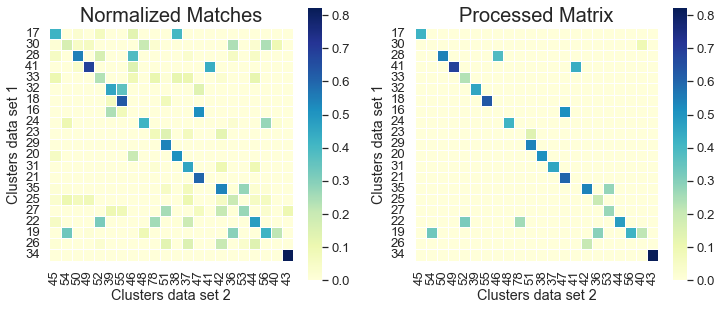

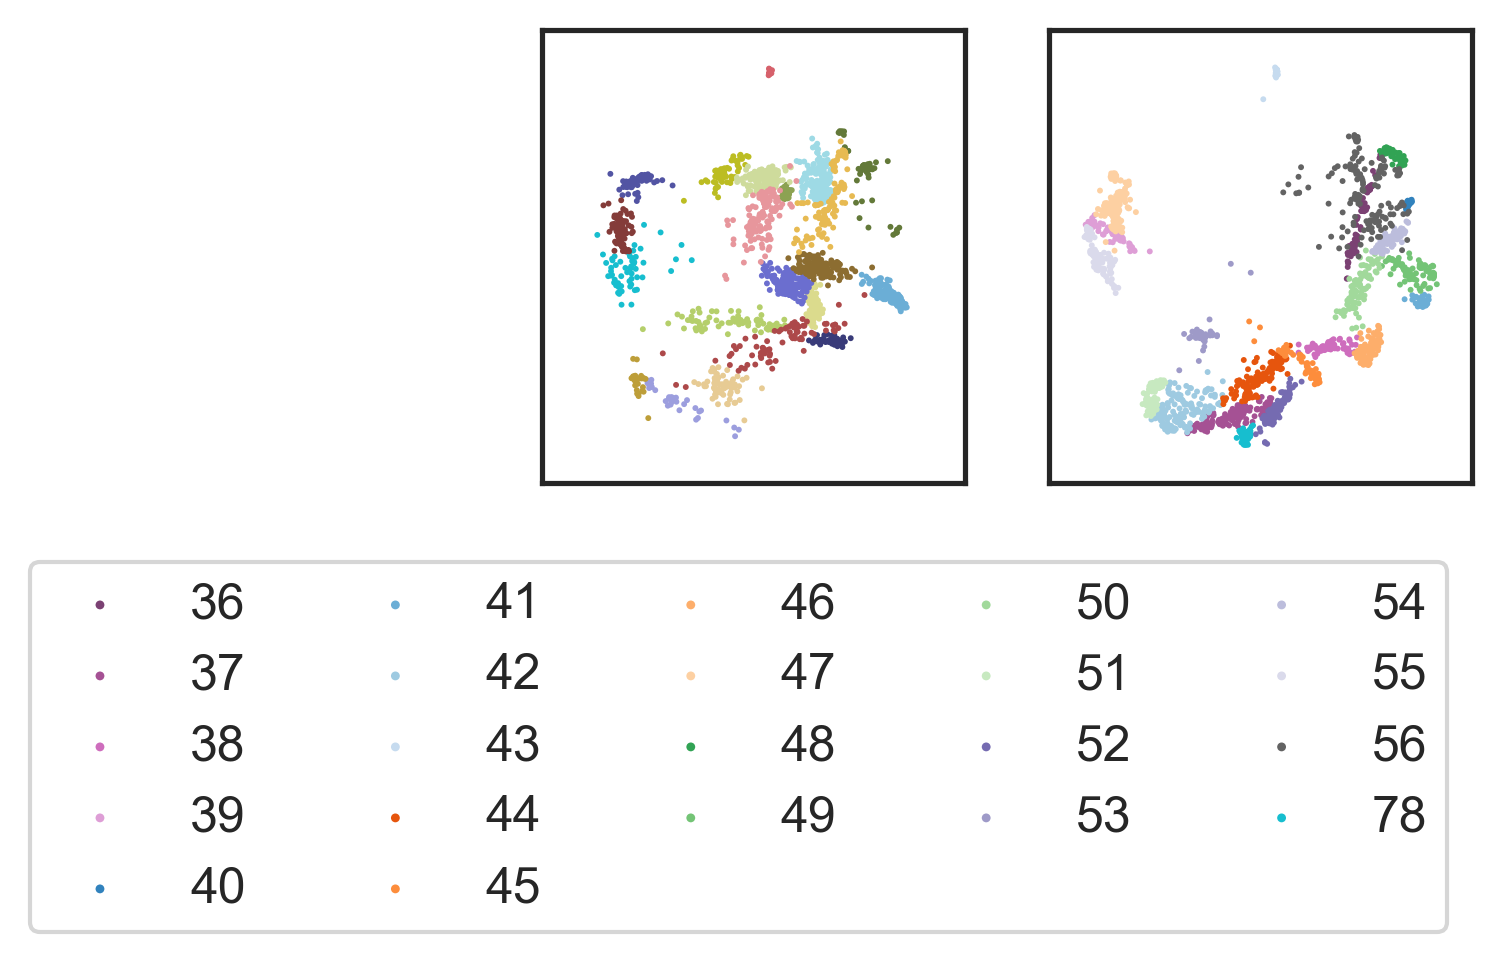

{17: [45], 30: [40], 28: [50, 46], 41: [49, 41], 33: [52], 32: [39], 18: [55], 16: [47], 24: [48], 23: [51], 29: [51], 20: [38], 31: [37], 21: [47], 35: [42, 53], 25: [36], 27: [53], 22: [52, 78, 44], 19: [54, 36, 56, 40], 26: [42], 34: [43]}


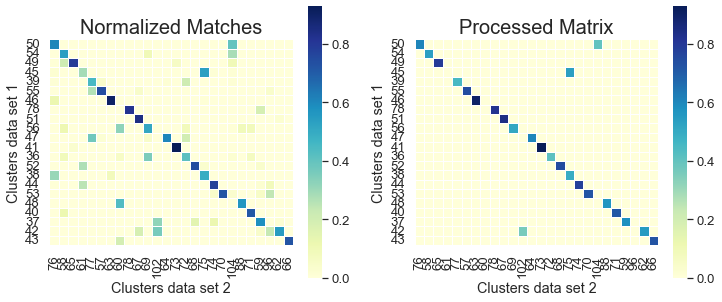

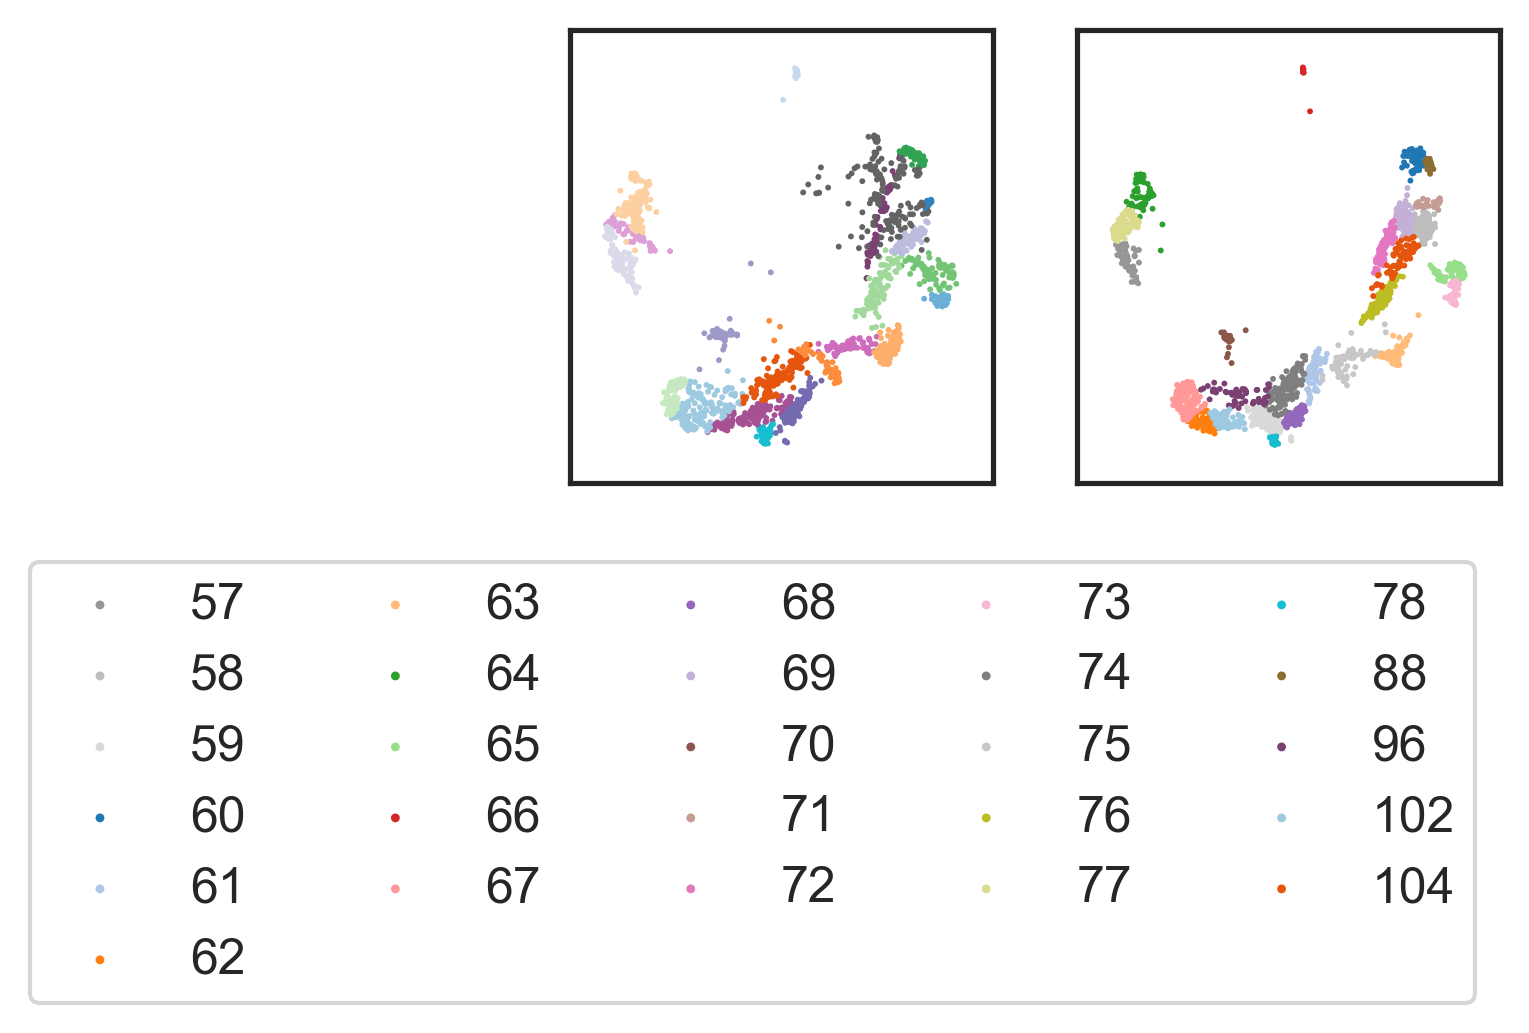

{50: [76, 104], 54: [58], 49: [65], 45: [75], 39: [77], 55: [57], 46: [63], 78: [78], 51: [67], 56: [69], 47: [64], 41: [73], 36: [72], 52: [68], 38: [75], 44: [74], 53: [70], 48: [88], 40: [71], 37: [59], 42: [102, 62], 43: [66]}


In [181]:
#from cellsaw.merge.draw import confuse
   
def basicMatch(labels1, labels2, data1, data2, hungmatch):

    ### This prevents some clusters from not being assigned
    ### to any clusters in the next time-slice
    threshold=0.5
    nonZeros=[0]
    while 0 in nonZeros and threshold>0:
        y1map, y2map, canvas = hungutil.make_canvas_and_spacemaps(labels1, labels2, hungmatch, normalize=True, dist = False)
        row_ind, col_ind = hungutil.solve_dense(canvas)
        canvas, canvasbackup = hungutil.clean_matrix(canvas, threshold=threshold)
        nonZeros=np.count_nonzero(canvas, axis=1)
        threshold-=0.01
    draw.doubleheatmap(canvasbackup, canvas, y1map, y2map, row_ind, col_ind)
    
    ### Get corresponding labels
    sorting = sorted(zip(col_ind, row_ind))
    col_ind, row_ind= list(zip(*sorting))

    # some rows are unused by the matching,but we still want to show them:
    order= list(row_ind) + list(set(y1map.integerlist)-set(row_ind) )
    canvas = canvas[order]
    x0labels = list(y2map.itemlist)
    y0labels = [y1map.getitem[r]for r in order]
    x,y=np.nonzero(-canvas)
    
    labelsMatch = {y0labels[x[i]]:[] for i in range(len(x))}
    for i in range(len(x)):
        labelsMatch[y0labels[x[i]]].append(x0labels[y[i]])
    draw.auto_tiny([data1, data2], [labels1, labels2], wrap='test', dim=(1,2), same_limit=True)
    
    return labelsMatch, canvas, (x0labels, y0labels)


labelsMatchList=[]
simMatrices=[]
xyLabs=[]
for i in range(len(tempData)-1):
    hungmatch, distances = util.hungarian(tempData[i], tempData[i+1])
    labelsMatch, canvas, xyLab = basicMatch(bestLabels[i].copy(), bestLabels[i+1].copy(), tempData[i].copy(), tempData[i+1].copy(), hungmatch)
    print(labelsMatch)
    labelsMatchList.append(labelsMatch)
    simMatrices.append(canvas)
    xyLabs.append(xyLab)



In [ ]:
from cellsaw.merge.draw import confuse
for i in range(len(tempData)-1):
    y1,y2 = confuse(bestLabels[i].copy(), bestLabels[i+1].copy())
    print(y1)
    print(y2)
 

In [182]:
def adjustLabels(lll, labelPairs, simMatrices, xyLabs):
    numTS = len(labelPairs)
    print(numTS)
    newDict =  [copy.deepcopy(d) for d in labelPairs]
    print(newDict)
    
    ### Adjust first time-point 
    xs = [e[0] for e in xyLabs]
    ys=[e[1] for e in xyLabs]
    #labelPairs = [copy.deepcopy(d) for d in newDict]
    print(labelPairs)

    ### Now iterate
    for i in range(numTS): #for maching between slice t and t+1
        print("")
        print(f"On Slice {i} working on slice {i+1}")
        canvas=simMatrices[i]
        x = xs[i]
        y = ys[i]
        #print(canvas)
        print(x)
        print(y)
        print("")
            
        for key,val in labelPairs[i].items():
            if len(val)>=2:
                if key not in val:
                    simScores = canvas[y.index(key),:]
                    valToReplace = x[np.argmin(simScores)]
                    if isInValues(newDict[i], valToReplace)<2:
                        print(f"replace valToReplace: {valToReplace} w key:{key}")
                        #if not isInValues(newDict[i], valToReplace):
                        print(val)
                        newDict[i][key][val.index(valToReplace)]=key
                        x = [key if el==valToReplace else el for el in x]
                        if i!=numTS-1:
                            ys[i+1] = [key if el==valToReplace else el for el in ys[i+1]]
                            newDict[i+1] = replace(key, valToReplace, newDict[i+1])
                            labelPairs[i+1] = replace(key, valToReplace, labelPairs[i+1])

                            #newDict[i+1][key] = newDict[i+1][valToReplace]
                            #del newDict[i+1][valToReplace]
                            #labelPairs[i+1][key] = labelPairs[i+1][valToReplace]
                            #del labelPairs[i+1][valToReplace]
                        lll[i+1] = [key if j==valToReplace else j for j in lll[i+1]]
                    
            elif len(val)==1 and key!=val[0]:
                ### Want to deal with circumstances where cluster goes to one cluster
                ### But they have different labels
                if isInValues(newDict[i], key)==0 and isInValues(newDict[i], val[0])==1:
                    print(f"replace val[0]: {val[0]} w key:{key}")
                    newDict[i][key]=[key]
                    x = [key if el==val[0] else el for el in x]
                    lll[i+1] = [key if v==val[0] else v for v in lll[i+1]]

                    if i!=numTS-1: #Update next slice labels
                        ys[i+1] = [key if el==val[0] else el for el in ys[i+1]]
                        newDict[i+1] = replace(key, val[0], newDict[i+1])
                        labelPairs[i+1] = replace(key, val[0], labelPairs[i+1])

                        #newDict[i+1][key] = newDict[i+1][val[0]]
                        #del newDict[i+1][val[0]]
                        #labelPairs[i+1][key] = labelPairs[i+1][val[0]]
                        #del labelPairs[i+1][val[0]]

                elif isInValues(newDict[i], key)>0 and isInValues(newDict[i], val[0])==1:
                    print(f"replace key: {key} w val[0]:{val[0]}")
                    newDict[i][val[0]] = val
                    lll[i] = [val[0] if v==key else v for v in lll[i]]
                    y = [val[0] if el==key else el for el in y]
                    del newDict[i][key]
                    
            
    return lll, newDict

def isInValues(dictObject, item):
    appearances=0
    for v in dictObject.values():
        if item in v:
            appearances+=1
    return appearances

def replace(key, toChange, dictObject):
    dictObject[key] = dictObject[toChange]
    del dictObject[toChange]
    return dictObject



4
[{7: [7], 4: [4], 9: [28], 14: [35, 9, 14], 5: [5], 2: [2], 3: [3], 15: [20], 6: [25], 0: [6], 8: [0, 8], 12: [12], 13: [10], 1: [15], 11: [1], 10: [10]}, {15: [22], 2: [19], 11: [22], 28: [41], 9: [28], 25: [25, 27], 20: [41, 17], 14: [28], 4: [30], 5: [20], 0: [21], 1: [26], 12: [23, 29], 3: [18], 6: [16], 35: [35], 10: [24], 8: [32], 7: [31], 13: [34]}, {17: [45], 30: [40], 28: [50, 46], 41: [49, 41], 33: [52], 32: [39], 18: [55], 16: [47], 24: [48], 23: [51], 29: [51], 20: [38], 31: [37], 21: [47], 35: [42, 53], 25: [36], 27: [53], 22: [52, 78, 44], 19: [54, 36, 56, 40], 26: [42], 34: [43]}, {50: [76, 104], 54: [58], 49: [65], 45: [75], 39: [77], 55: [57], 46: [63], 78: [78], 51: [67], 56: [69], 47: [64], 41: [73], 36: [72], 52: [68], 38: [75], 44: [74], 53: [70], 48: [88], 40: [71], 37: [59], 42: [102, 62], 43: [66]}]
[{7: [7], 4: [4], 9: [28], 14: [35, 9, 14], 5: [5], 2: [2], 3: [3], 15: [20], 6: [25], 0: [6], 8: [0, 8], 12: [12], 13: [10], 1: [15], 11: [1], 10: [10]}, {15: [22

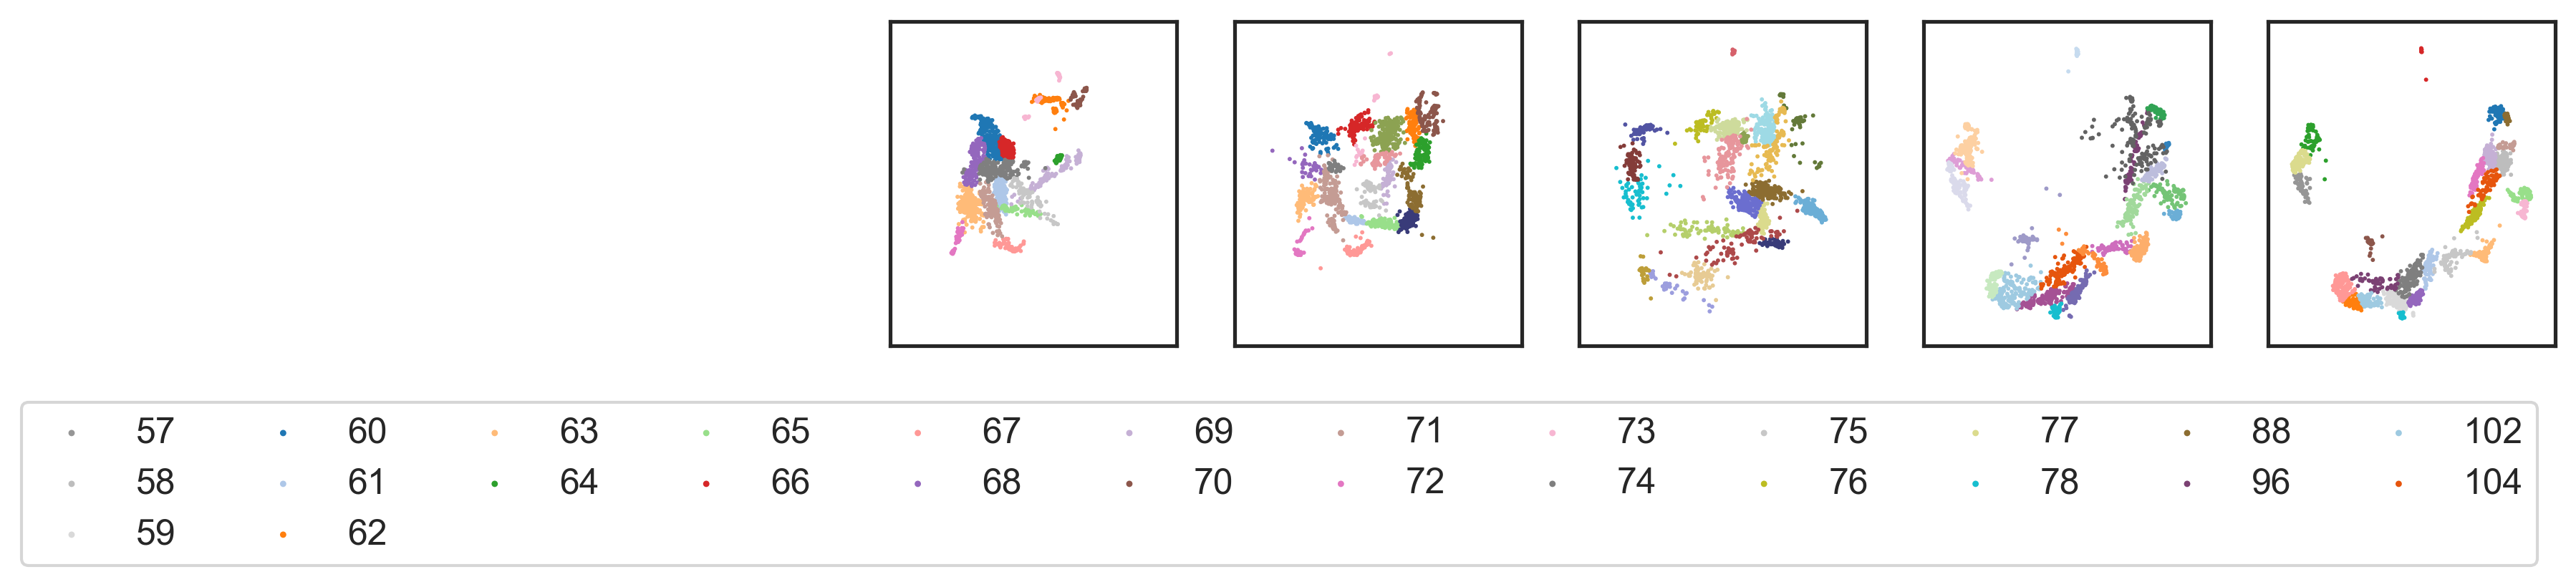

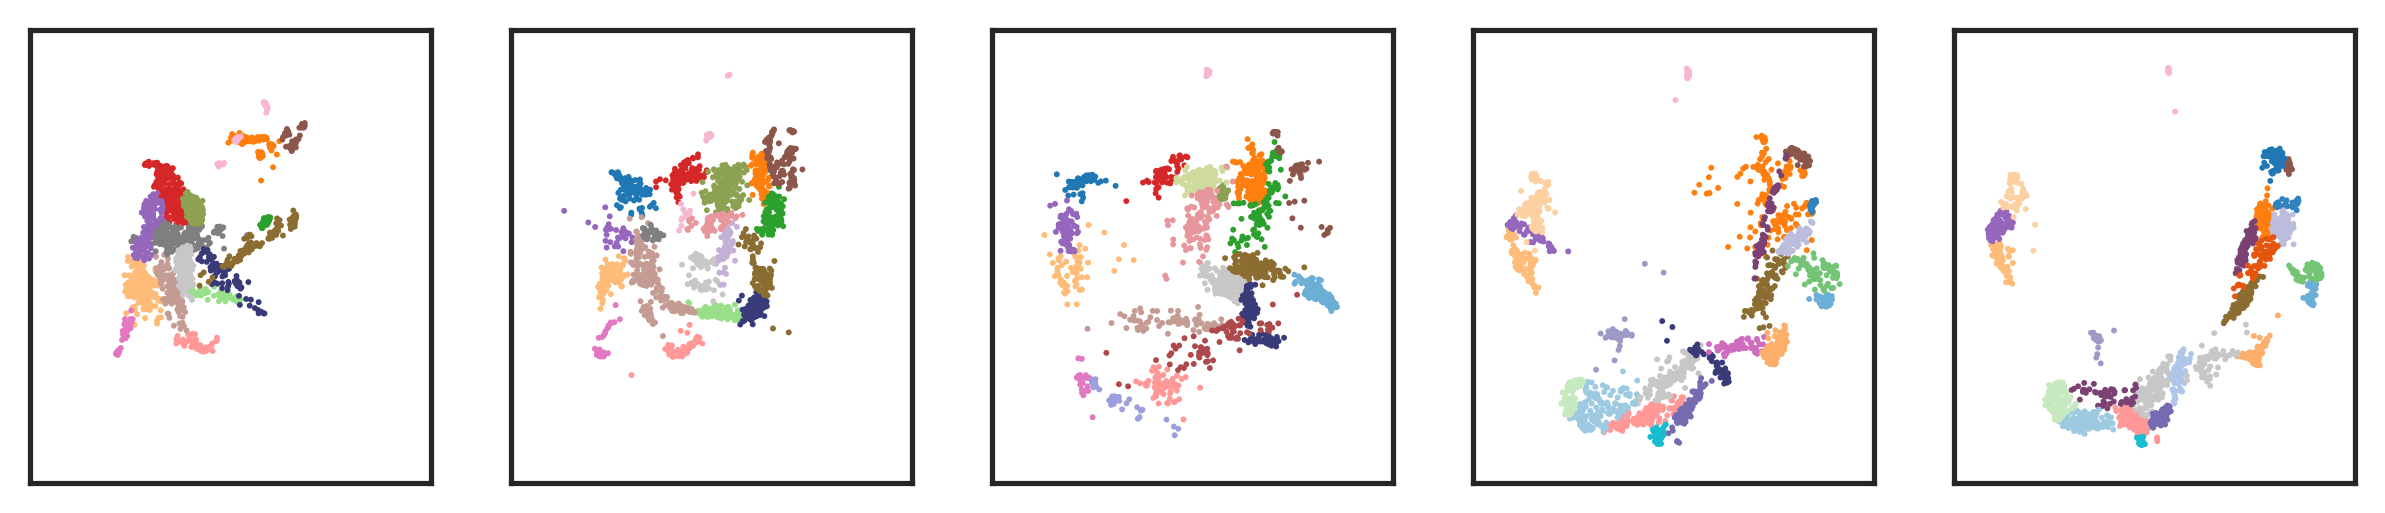

In [184]:
import copy

    
lll = [l.copy() for l in bestLabels]
labelPairs = [copy.deepcopy(d) for d in labelsMatchList]

for i in range(1):
    lll, labelPairs = adjustLabels(lll, labelPairs, simMatrices, xyLabs)

print("")
print("Original Evolution Pairs")
for d in labelsMatchList:
    print(d)
print("Final Evolution Pairs")
for d in labelPairs:
    print(d)
            
perfectLabels=lll
#print(lll)
draw.auto_tiny(tempData, bestLabels, wrap='test', dim=(1,len(tempData)), same_limit=True)
draw.auto_tiny(tempData, perfectLabels, wrap='test', dim=(1,len(tempData)), same_limit=True, legend=False)

{7: [7], 4: [4], 14: [35, 9, 14], 5: [5], 2: [2], 3: [3], 8: [0, 8], 12: [12], 13: [10], 11: [11], 10: [10], 28: [28], 20: [20], 25: [25], 6: [6], 15: [15]}
{15: [15], 2: [2], 11: [11], 28: [41], 9: [28], 25: [25, 27], 20: [41, 20], 14: [28], 4: [4], 5: [20], 0: [0], 12: [23, 12], 3: [3], 6: [6], 35: [35], 10: [10], 8: [8], 7: [7], 13: [13]}
{28: [28, 46], 41: [49, 41], 33: [52], 23: [51], 20: [20], 35: [42, 53], 25: [36], 27: [53], 15: [52, 78, 15], 2: [54, 36, 2, 40], 11: [42], 4: [40], 0: [47], 12: [51], 3: [3], 6: [47], 10: [10], 8: [8], 7: [7], 13: [13]}
{54: [54], 49: [49], 46: [46], 78: [78], 51: [51], 47: [47], 41: [41], 36: [36], 52: [52], 38: [75], 53: [53], 40: [40], 42: [102, 42], 28: [28, 104], 20: [75], 15: [15], 2: [2], 3: [3], 10: [10], 8: [8], 7: [7], 13: [13]}


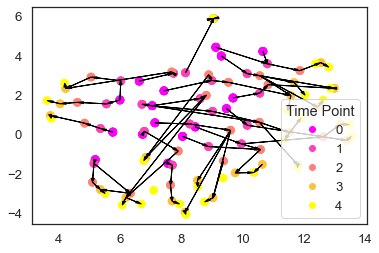

In [175]:
### Plot finally the whole connections



### Calc Cluster Centres
### This is then used to match main clusters before finding pairings 
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

    ### labelPairs has the matchings
def scatterPoints(clusterCentres):
    col = []
    toShow = np.empty((0,2), dtype=float)
    for i,d in enumerate(clusterCentres):
        v = np.vstack(list(d.values()))
        col = col+[i for x in range(len(v))]
        toShow=np.vstack((toShow,v))
        scatter = plt.scatter(toShow[:,0], toShow[:,1], c=col, s=60, cmap='spring')
    return scatter

Y = perfectLabels
'''
clusterCentresR2 = [{} for i in range(len(Y))]
for i, (l,d) in enumerate(zip(Y, tempData)):
    for n in np.unique(l):
        dMean = np.mean(d[np.where(l==n)[0]], axis=0)
        clusterCentresR2[i][n]=list(dMean)
    print(clusterCentresR2[i])
    print('\n')
'''

clusterCentresR2 = getClusterCentres(Y, tempData)
'''
col = []
toShow = np.empty((0,2), dtype=float)
for i,d in enumerate(clusterCentresR2):
    v = np.vstack(list(d.values()))
    col = col+[i for x in range(len(v))]
    toShow=np.vstack((toShow,v))
    
scatter = plt.scatter(toShow[:,0], toShow[:,1], c=col, s=60, cmap='spring')
'''
scatter = scatterPoints(clusterCentresR2)

for i in range(len(labelPairs)):
    print(labelPairs[i])
    d1=clusterCentresR2[i]
    d2=clusterCentresR2[i+1]
    for key,val in labelPairs[i].items():
        for v in val:
            plt.arrow(d1[key][0], d1[key][1], d2[v][0]-d1[key][0], d2[v][1]-d1[key][1], length_includes_head=True,
          head_width=0.1, head_length=0.2, color='black')
    
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[i for i in range(len(tempData))],
           title="Time Point")
plt.show()

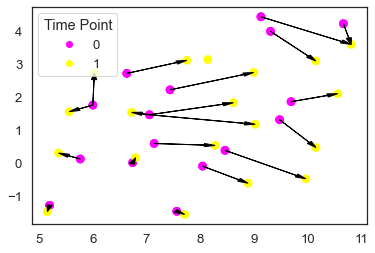

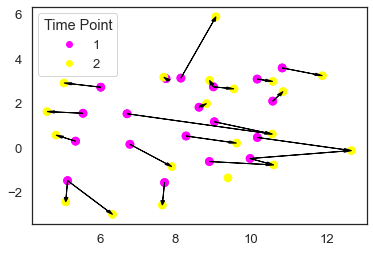

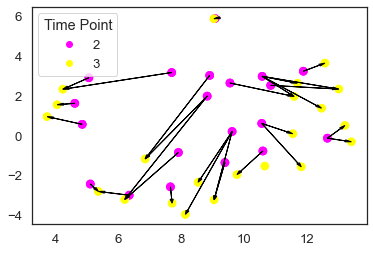

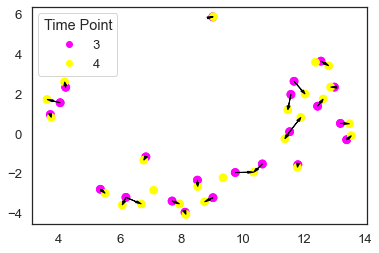

In [176]:
### Plot the same arrow scatter but this time one plot for each time point

#clusterCentresR2 contains the centres at each time point i


col = []
toShow = np.empty((0,2), dtype=float)
for i in range(len(labelPairs)):
    d1 = clusterCentresR2[i]
    d2 = clusterCentresR2[i+1]
    '''
    v1 = np.vstack(list(d1.values()))
    v2 = np.vstack(list(d2.values()))
    col = [i for x in range(len(v1))]+[i+1 for x in range(len(v2))]
    toShow=np.vstack((v1,v2))
    scatter = plt.scatter(toShow[:,0], toShow[:,1], c=col, s=60, cmap='spring')
    '''
    scatter = scatterPoints([d1,d2])
    for key,val in labelPairs[i].items():
        for v in val:
            plt.arrow(d1[key][0], d1[key][1], d2[v][0]-d1[key][0], d2[v][1]-d1[key][1], length_includes_head=True,
          head_width=0.1, head_length=0.2, color='black')
    
    plt.legend(handles=scatter.legend_elements()[0], 
            labels=[i,i+1],
            #labels=[i for i in np.unique(col)],
           title="Time Point")
    plt.show()

In [599]:
### Calc ARI for these labels
for index, l in enumerate(Labels):
    #print(f"Labels: {tempLabels[index].shape}, 2d: {labels2D[index].shape}")
    print(f"ARI:{index} {ARI(tempLabels[index], perfectLabels[index])}")
print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in perfectLabels for item in sublist])}")


NameError: name 'perfectLabels' is not defined

In [10]:

#from natto.process.cluster import hungutil
from natto.process import differentiate
#from differentiate import cellDifferentiationPipeline as CDP

In [91]:
importlib.reload(differentiate)
importlib.reload(draw)
#importlib.reload(hungutil)


<module 'natto.out.draw' from '/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/natto/natto/out/draw.py'>

Clusering Data 4
Counter({1: 819, 0: 416, 2: 386, 3: 379})
Best cluster is 4


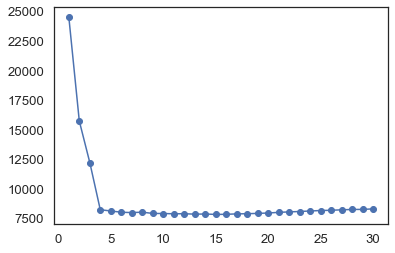

Best Number of Clusters for slice 4 is 4

Clusering Data 3
Counter({1: 422, 2: 413, 0: 410, 3: 402, 4: 353})
Best cluster is 5


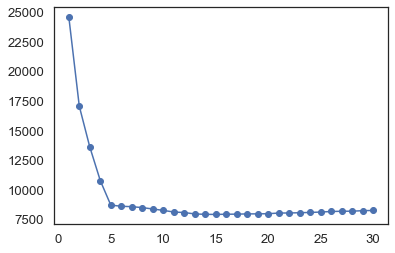

Best Number of Clusters for slice 3 is 5

Clusering Data 2
Counter({0: 419, 1: 416, 4: 403, 3: 398, 2: 364})
Best cluster is 5


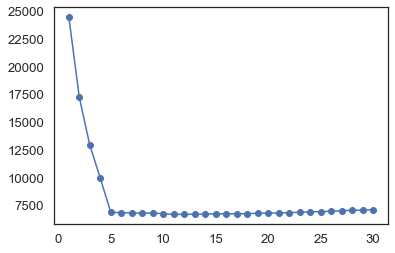

Best Number of Clusters for slice 2 is 5

Clusering Data 1
Counter({3: 413, 0: 408, 1: 404, 2: 395, 4: 380})
Best cluster is 5


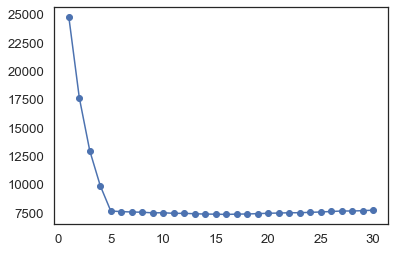

Best Number of Clusters for slice 1 is 5

Clusering Data 0
Counter({0: 820, 2: 406, 1: 388, 3: 386})
Best cluster is 4


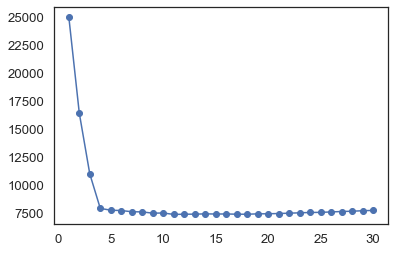

Best Number of Clusters for slice 0 is 4



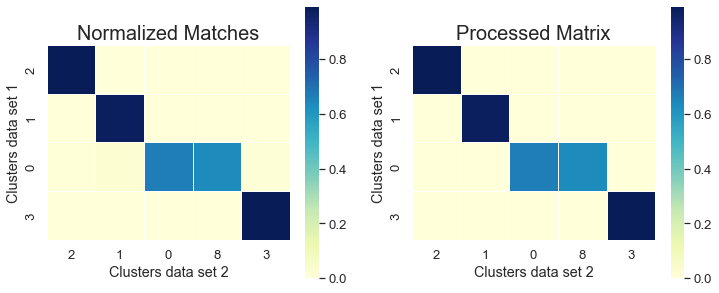

{2: [2], 1: [1], 0: [0, 8], 3: [3]}


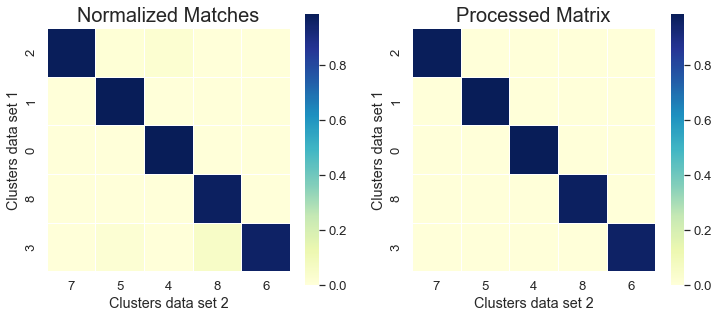

{2: [7], 1: [5], 0: [4], 8: [8], 3: [6]}


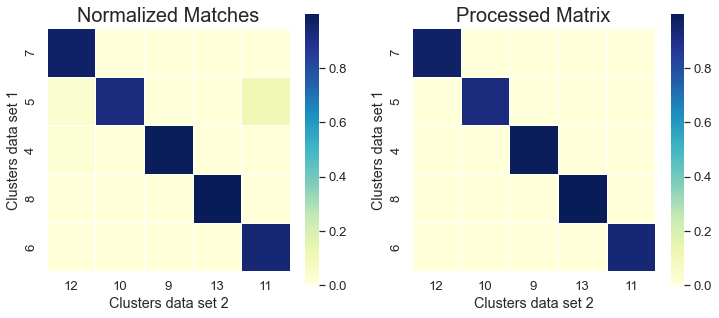

{7: [12], 5: [10], 4: [9], 8: [13], 6: [11]}


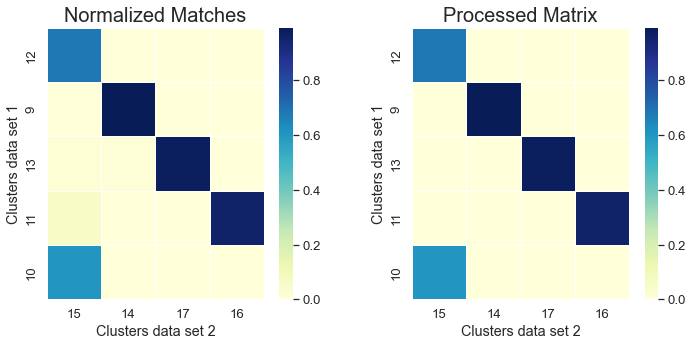

{12: [15], 9: [14], 13: [17], 11: [16], 10: [15]}
{2: [2], 1: [1], 0: [0, 8], 3: [3]}
{2: [7], 1: [5], 0: [4], 8: [8], 3: [6]}
{7: [12], 5: [10], 4: [9], 8: [13], 6: [11]}
{12: [15], 9: [14], 13: [17], 11: [16], 10: [15]}
replace val[0]: 7 w key:2
replace val[0]: 5 w key:1
replace val[0]: 4 w key:0
replace val[0]: 6 w key:3
replace val[0]: 13 w key:8
replace val[0]: 12 w key:2
replace val[0]: 10 w key:1
replace val[0]: 9 w key:0
replace val[0]: 11 w key:3
replace val[0]: 17 w key:8
replace val[0]: 14 w key:0
replace val[0]: 16 w key:3
[ 0  1  2  3  8 15]


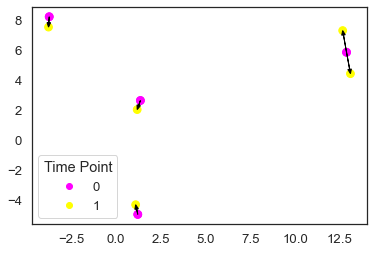

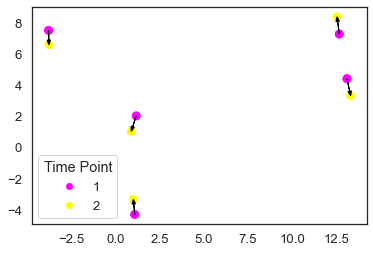

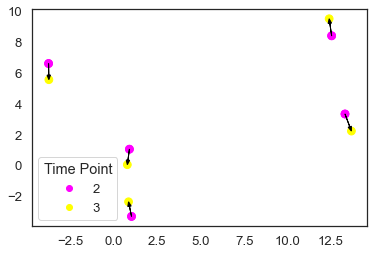

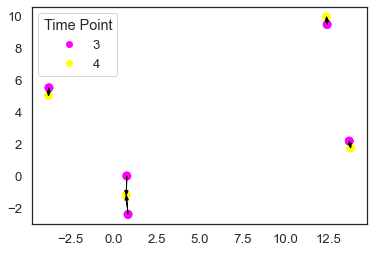

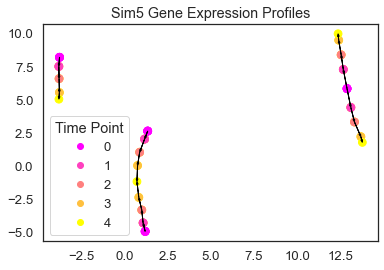

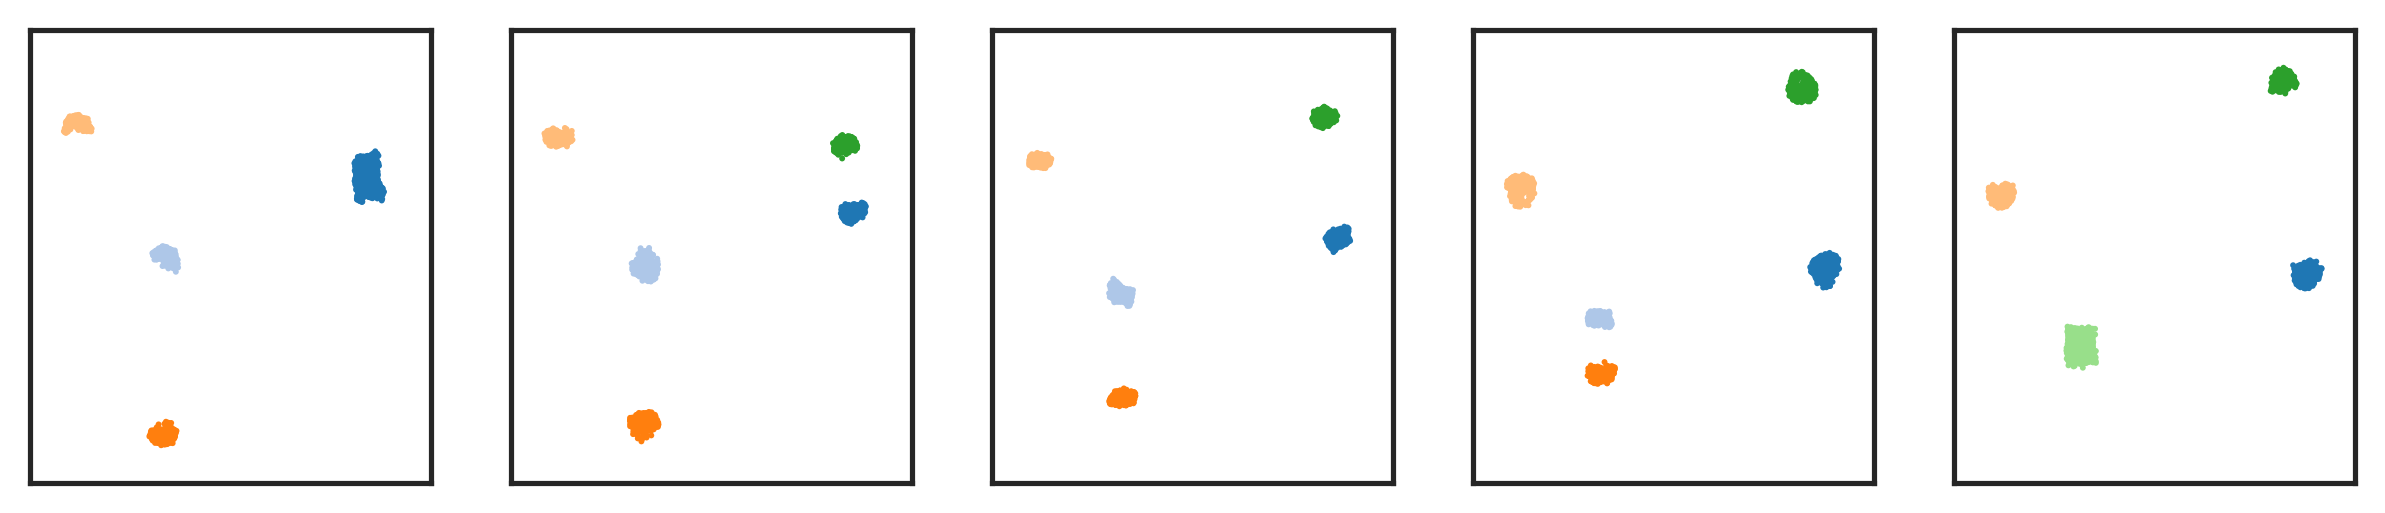

Finished 34.30296492576599s


In [71]:
tempData2 = [x.copy() for x in transformedData]
#tempData2 = [np.vstack(tempData2)]

time0 = time.time()
debug=True
max_components = 30
minClusters = 1
minClusterSize = 1
requireLessClusters = False
optMethod = 'uber' #'kneed', 'uber', 'BIC', 'uberBIC', AdjBIC', 'AIC', 'uberAIC'
BICPenalty = 1
gmmMethod = 'full'
labelsXD, labelPairsXD = differentiate.cellDifferentiationPipeline(tempData2, 
                                                                   max_components=max_components,
                                                                   minClusters=minClusters,
                                                                   minClusterSize=minClusterSize,
                                                                   optMethod=optMethod, 
                                                                   gmmMethod=gmmMethod, 
                                                                   plotOpt=True,
                                                                   plotIntermediateTiny=False,
                                                                   requireLessClusters=requireLessClusters,
                                                                   BICPenalty=BICPenalty,
                                                                   title='Sim5 Gene Expression Profiles',
                                                                   debug=debug)

print(f"Finished {time.time()-time0}s")

Clusering Data 4
Counter({1: 819, 0: 416, 2: 386, 3: 379})
Best cluster is 4
Best Number of Clusters for slice 4 is 4

Clusering Data 3
Counter({1: 422, 2: 413, 0: 410, 3: 402, 4: 353})
Best cluster is 5
Best Number of Clusters for slice 3 is 5

Clusering Data 2
Counter({0: 419, 1: 416, 4: 403, 3: 398, 2: 364})
Best cluster is 5
Best Number of Clusters for slice 2 is 5

Clusering Data 1
Counter({3: 413, 0: 408, 1: 404, 2: 395, 4: 380})
Best cluster is 5
Best Number of Clusters for slice 1 is 5

Clusering Data 0
Counter({0: 820, 2: 406, 1: 388, 3: 386})
Best cluster is 4
Best Number of Clusters for slice 0 is 4



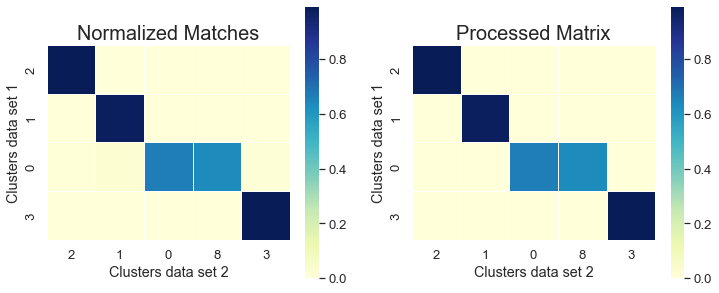

{2: [2], 1: [1], 0: [0, 8], 3: [3]}


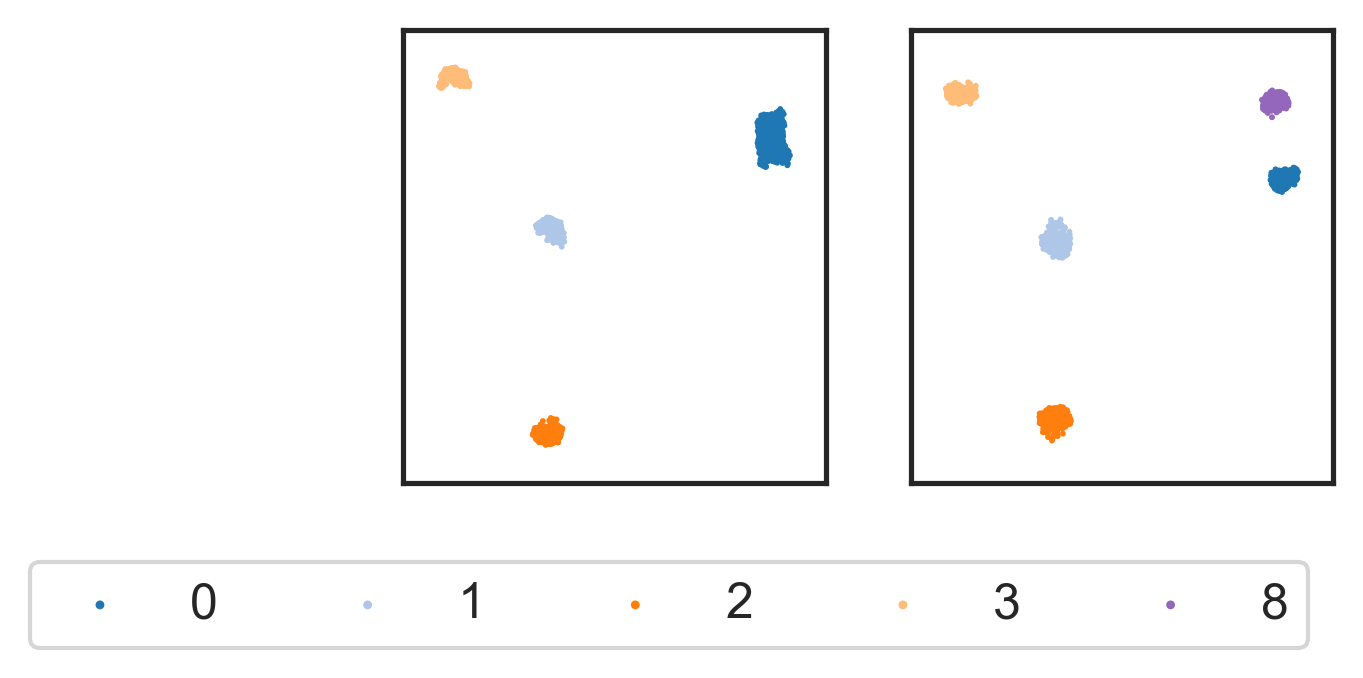

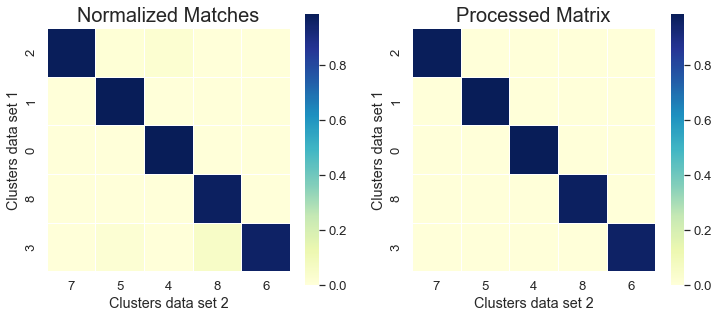

{2: [7], 1: [5], 0: [4], 8: [8], 3: [6]}


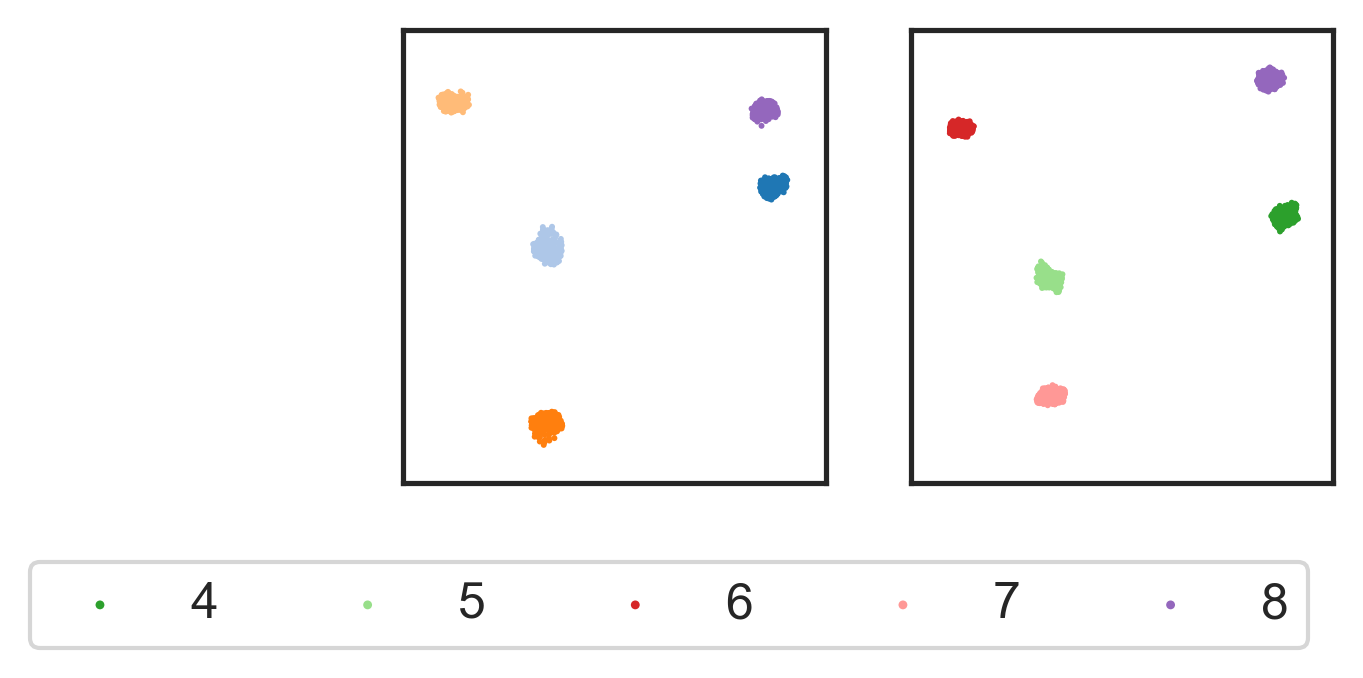

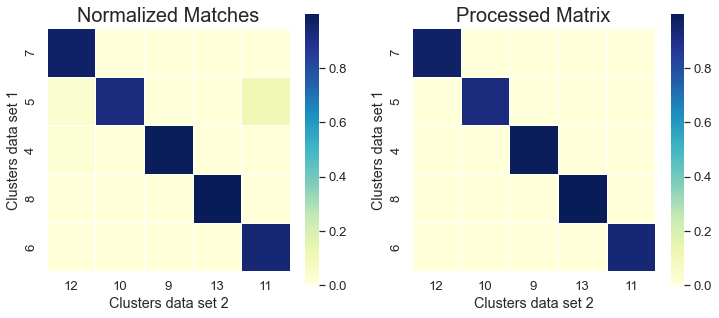

{7: [12], 5: [10], 4: [9], 8: [13], 6: [11]}


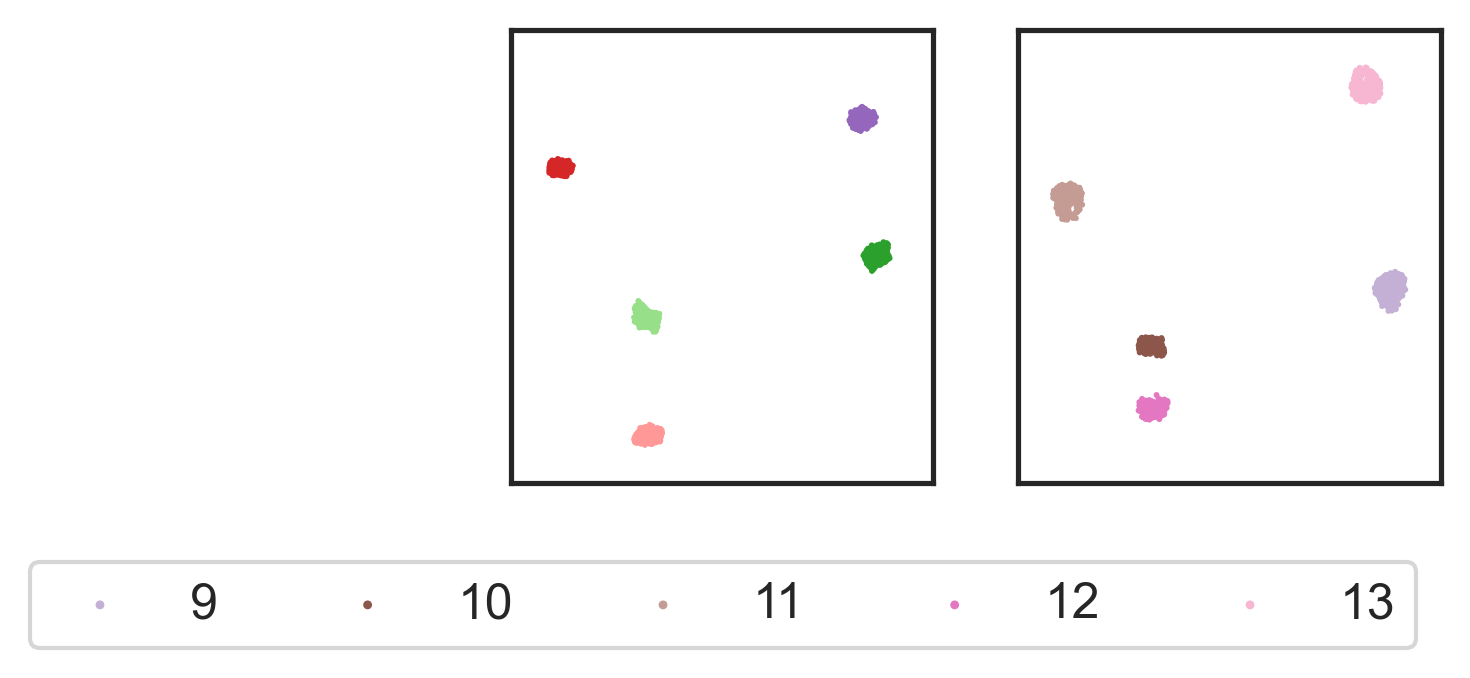

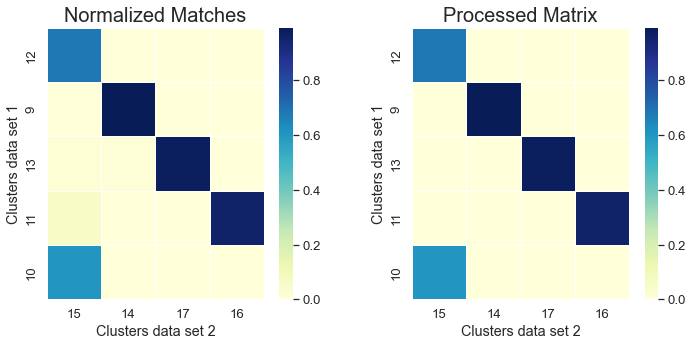

{12: [15], 9: [14], 13: [17], 11: [16], 10: [15]}


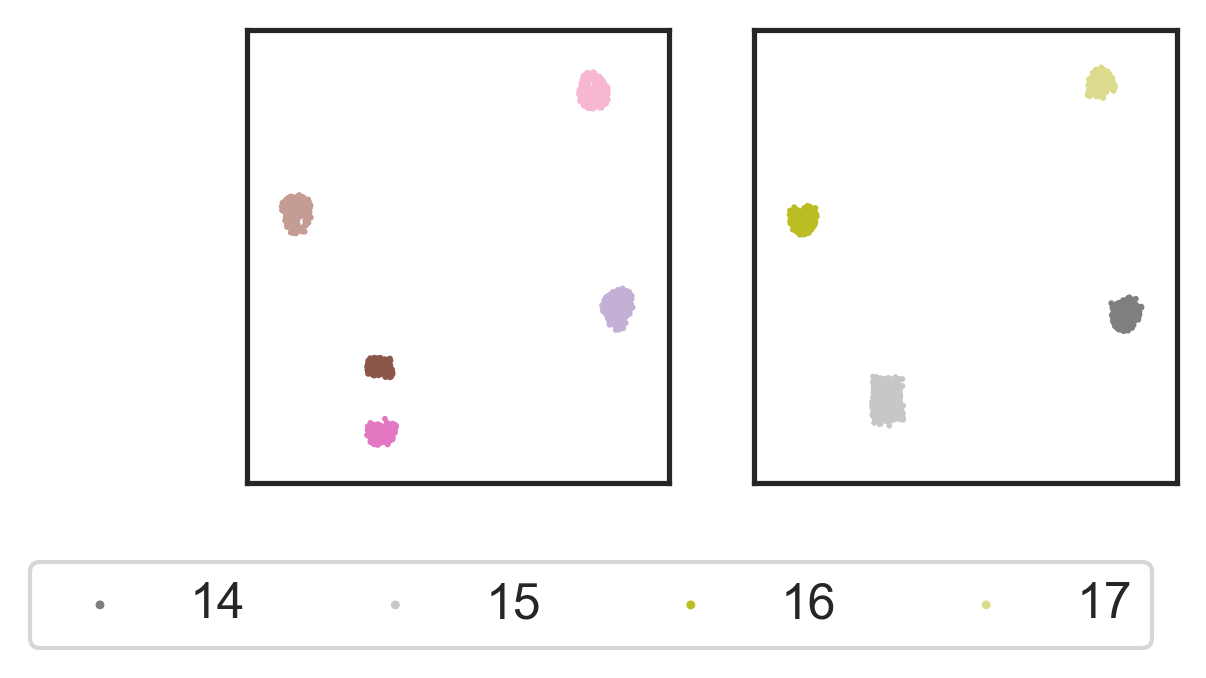

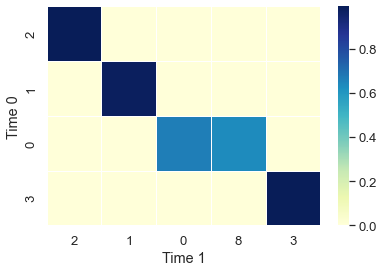

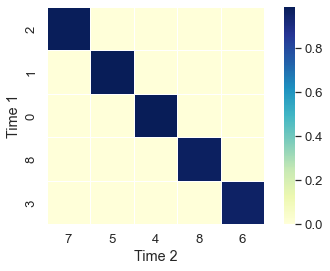

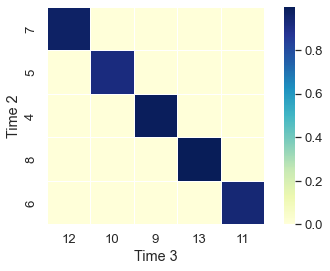

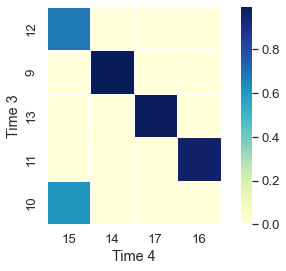

[array([[-0.99145299,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.97979798,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.66449511, -0.63333333,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -0.98847631]]),
 array([[-0.98150432,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.98536585,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.98669891,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.9706258 ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -0.95915679]]),
 array([[-0.97073171,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.91807542,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.98914355,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.99875776,  0.        ],
        [ 0.        ,

In [92]:
differentiate.getCanvases(tempData2, max_components=35, 
    minClusters=1, 
    minClusterSize=1, 
    optMethod='uber', 
    gmmMethod='full',
    requireLessClusters=False,
    BICPenalty=np.e,
    title=None,
    save='Sim5_confusion_Time')

{5: [2], 3: [3], 0: [7], 2: [2], 1: [3], 7: [7], 6: [2], 4: [7]}
{2: [2, 9], 3: [3, 10], 7: [8, 7]}
{10: [10], 8: [11], 9: [11], 2: [2], 3: [3], 7: [7]}
ARI:0 0.3606080348048646
ARI:1 0.44660215081839516
ARI:2 0.5658443815408657
ARI:3 0.5843211907676727
Overall ARI: 0.3726301638521338
2 to:
2


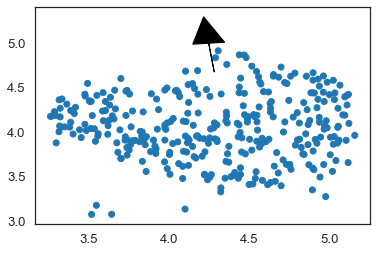

2 to:
2
9


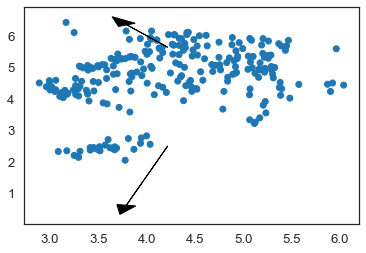

2 to:
2
9 to:
11


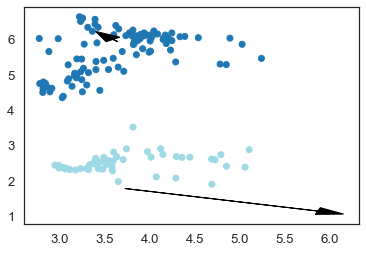

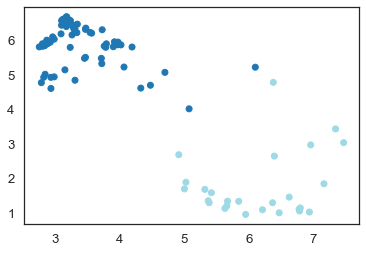

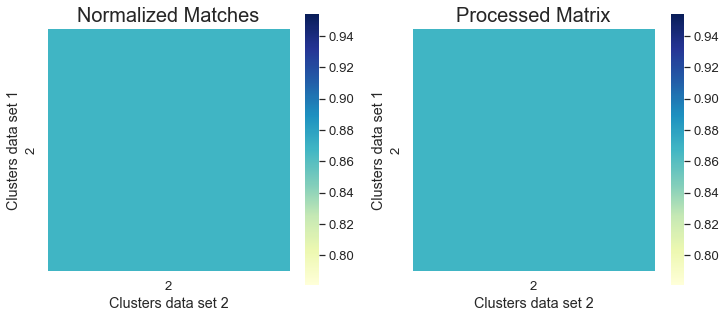

{2: [2]}


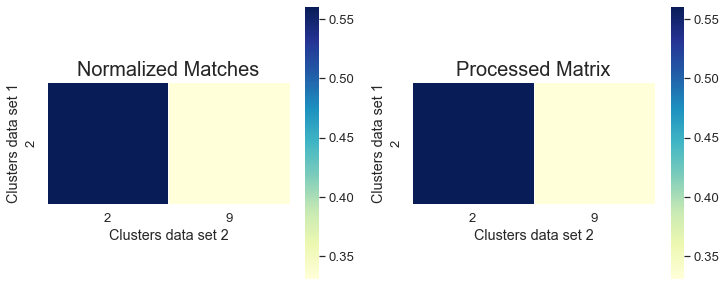

{2: [2, 9]}


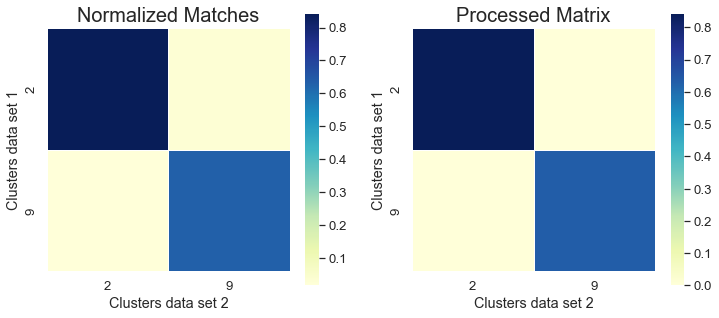

{2: [2], 9: [9]}
[2 9]


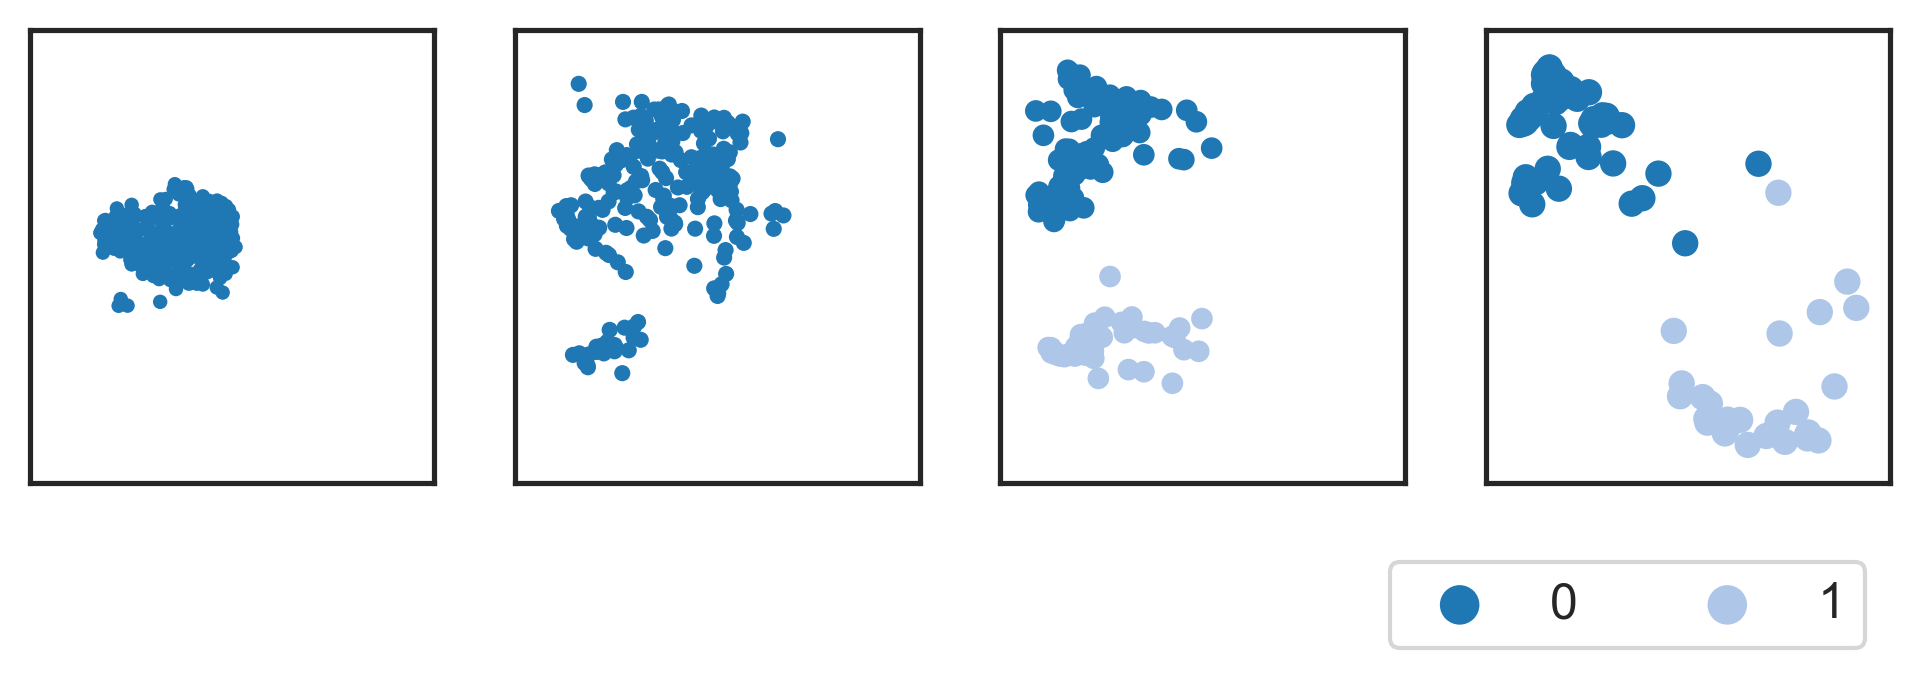

In [54]:
for l in labelPairsXD:
    print(l)
### Calc ARI for these labels
for index, l in enumerate(Labels):
    #print(f"Labels: {tempLabels[index].shape}, 2d: {labels2D[index].shape}")
    print(f"ARI:{index} {ARI(tempLabels[index], labelsXD[index])}")
print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labelsXD for item in sublist])}")

def clusterTrace(data, labels, labelPairs, targets):
    dataToShow=[]
    labelsToShow =[]
    data = [np.asarray(d) for d in data]
    labels = [np.asarray(l) for l in labels]
    if type(targets)!=list:
        targets = [targets]
    if targets[0] in labelPairs[0].keys():
        clusterCentres = getClusterCentres2(labels, data)
        for i,l in enumerate(labelPairs):
            dataToShow, labelsToShow = getDrawStuff(data[i], labels[i], dataToShow, labelsToShow, targets)
            plt.scatter(dataToShow[-1][:,0], dataToShow[-1][:,1], c=labelsToShow[-1], cmap='tab20')#, c=np.unique(labelsToShow[-1]))
            plotArrows2(clusterCentres[i], clusterCentres[i+1], labelPairs[i], targets)
            plt.show()

            targets = [item for t in targets for item in l[t]]
            
        dataToShow, labelsToShow = getDrawStuff(data[-1], labels[-1], dataToShow, labelsToShow, targets)
        plt.scatter(dataToShow[-1][:,0], dataToShow[-1][:,1], c=labelsToShow[-1], cmap='tab20')
        plt.show()
    
    labelsToShow = differentiate.prelimAlign(labelsToShow, dataToShow)
    labelsMatchList, simMatrices, xyLabs = differentiate.clusterMatch(labelsToShow, dataToShow, threshold=0.5, plotIntermediateTiny=False)
    labelsToShow, labelPairsTemp = differentiate.adjustLabels(labelsToShow, labelsMatchList, simMatrices, xyLabs, debug=debug)
    labelsToShow, labelPairsTemp = differentiate.reduceLabels(labelsToShow, labelPairsTemp)
    
    draw.auto_tiny(dataToShow, labelsToShow, wrap='test', dim=(1,len(dataToShow)), same_limit=True)
    
def getDrawStuff(data, labels, dataToShow, labelsToShow, targets):
    mask = [i for i,label in enumerate(labels) for t in targets  if label==t]
    dataToShow.append(data[mask])
    labelsToShow.append(labels[mask])
    return dataToShow, labelsToShow

def getClusterCentres2(labels, data):
    ### Find centres of each cluster
    clusterCentres = [{} for i in range(len(labels))]
    for i, (l,d) in enumerate(zip(labels, data)):
        for n in np.unique(l):
            dMean = np.mean(d[np.where(l==n)[0]], axis=0)
            clusterCentres[i][n]=list(dMean)
    return clusterCentres

def plotArrows2(clusterCentres1, clusterCentres2, pairs, targets):
        d1=clusterCentres1
        d2=clusterCentres2
        for t in targets:
            print(f"{t} to:")
            for v in pairs[t]:
                print(v)
                plt.arrow(d1[t][0], d2[v][1], d2[v][0]-d1[t][0], d2[v][1]-d1[t][1], length_includes_head=True,
                  head_width=0.2, head_length=0.3, color='black')

     

whichCluster = 2
clusterTrace(tempData, labelsXD, labelPairsXD, whichCluster)
    

In [254]:
from cellsaw.merge.draw import confuse
for i in range(len(tempData)-1):
    y1,y2 = confuse(bestLabels[i].copy(), bestLabels[i+1].copy())
    print(y1)
    print(y2)
    #labelsMatchList.append(labelsMatch)
    #simMatrices.append(canvas)
    #xyLabs.append(xyLab)


KeyError: 9

In [112]:
labelsCopy = [l.copy() for l in labelsXD]
labelPairsCopy=  [copy.deepcopy(d) for d in labelPairsXD]
#print(labelPairsCopy)
labelsStacked = np.hstack(labelsCopy)
print(labelsStacked[0:20])
print(labelsStacked.shape)
uniqueLabels = np.unique(labelsStacked)
print(uniqueLabels)
for i,(new,old) in enumerate(zip(range(max(uniqueLabels)), uniqueLabels)):
    if new!=old and new<len(uniqueLabels):
        ### Replace ul with ol
        for index, label in enumerate(labelsCopy):
            labelsCopy[index] = [new if l==old else l for l in labelsCopy[index]]
            if index!=len(labelPairsCopy):
                labelPairsCopy[index] = {(new if key==old else key):val for key,val in labelPairsCopy[index].items()}
                for key, val in labelPairsCopy[index].items():
                    if old in val:
                        labelPairsCopy[index][key] = [new if v==old else v for v in val]
            #if ul in labelPairsCopy[index].keys():
                #labelPairsCopy[ol] = 
            
print(np.unique(np.hstack(labelsCopy)))

print()
print(labelsCopy[0][0:20])
print("")
for i, l in enumerate(labelPairsXD):
    print(labelPairsXD[i])
    print(labelPairsCopy[i])
    print("")

[0 2 2 2 2 2 0 2 1 2 2 2 0 0 0 2 2 2 0 1]
(3452,)
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]

[0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1]

{0: [0], 2: [3, 4, 2], 1: [1]}
{0: [0], 2: [3, 4, 2], 1: [1]}

{0: [0], 3: [3, 4, 7], 4: [4], 1: [1], 2: [2]}
{0: [0], 3: [3, 4, 7], 4: [4], 1: [1], 2: [2]}

{4: [4], 7: [7], 0: [0, 5], 1: [1, 6], 2: [2, 8]}
{4: [4], 7: [7], 0: [0, 5], 1: [1, 6], 2: [2, 8]}



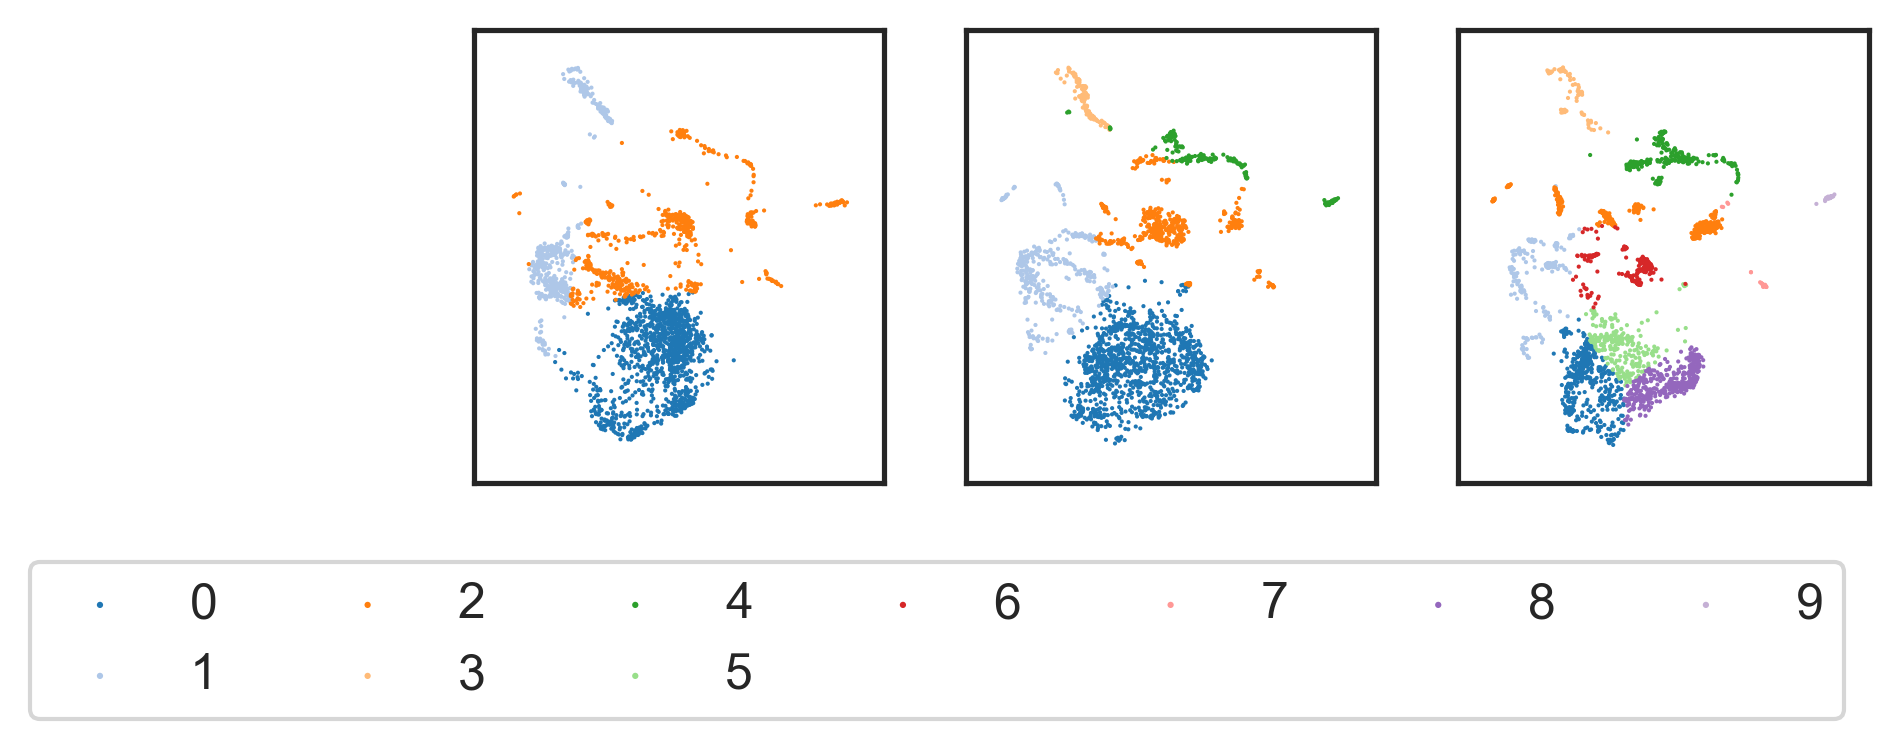

In [171]:
draw.auto_tiny(tempData, labelsCopy, wrap='test', dim=(1,len(tempData)), same_limit=True)

In [463]:
labelPairsCopy=  [copy.deepcopy(d) for d in labelPairsXD]
print(labelPairsCopy)
for i,(new,old) in enumerate(zip(range(max(uniqueLabels)), uniqueLabels)):
    if new not in uniqueLabels:
        for index in range(len(labelPairsCopy)):
            for k,v in labelPairsCopy[index].items():
                if old in v:
                    labelPairsCopy[index][k] = [new if item==old else item for item in labelPairsCopy[index][k]]

            if old in labelPairsCopy[index].keys():
                labelPairsCopy[index][new] = labelPairsCopy[index][old]
                del labelPairsCopy[index][old]

#print(labelPairs)
print("\n")
print(labelPairsCopy)

[{4: [4], 9: [9, 21], 3: [3, 11], 5: [5], 7: [7], 8: [8], 1: [1, 26], 0: [0, 12], 6: [6], 10: [10, 14], 2: [2], 23: [23]}, {4: [4], 21: [21], 7: [27], 5: [5], 14: [14], 3: [3, 15], 8: [8], 2: [2, 36], 11: [22, 11], 0: [27], 23: [37, 23], 9: [9, 47], 6: [6], 1: [1, 13], 10: [10, 25], 12: [12], 26: [26]}]


[{4: [4], 9: [9, 16], 3: [3, 11], 5: [5], 7: [7], 8: [8], 1: [1, 20], 0: [0, 12], 6: [6], 10: [10, 14], 2: [2], 18: [18]}, {4: [4], 7: [27], 5: [5], 14: [14], 3: [3, 15], 8: [8], 2: [2, 36], 11: [17, 11], 0: [27], 9: [9, 24], 6: [6], 1: [1, 13], 10: [10, 19], 12: [12], 16: [16], 18: [37, 18], 20: [20]}]
